<h1><span style="color:blue">Toward a warranty of micro-simulators for mixed traffic assessement: <br> 
    can we pass the prerequirement of test-cases definition? </span></h1> 

CLUMITISI: Clustering Mixed Traffic Situations <br> 
@author: Thibault Charlottin <br>
@contributor: Christine Buisson <br>
Licit-Eco7, 2022

This script is devoted to realize simulations corresponding to a wide variety of freeway mixed (Automated Cruise Control and Human Driven Vehicles) traffic situations and to cluster them with three classical clustering methods. The script is working on top of the Sumo code that you must install (in the Windows version) before processing the current script.

The first part allows you to create simulations on SUMO with two car-following models and to compute them. In the second and third parts you can analyse and cluster obtained data.

It was developped by Thibault Charlottin during his master internship April-August 2022, under the supervision of Christine Buisson in the LICIT-ECO7 Lab, in Lyon, France. https://licit-lyon.eu/

It is divided into parts:<br>
- 1st part: file simulation using Traci module 
- 2nd part: indicators definition and computation
- 3rd part: indicator clustering and plot editing<br>

SUMO can be downloaded for windows version (the only one working with this code) at
    https://sumo.dlr.de/docs/Downloads.php

This source is provided upon the Eclipse Public License 2.0 (see: https://www.eclipse.org/legal/epl-2.0/)

In the following, the comments are in English but some of the variables names are in French.


**Warning #1 the Traci librairies are Windows based, the simulation section won't work on Mac**<br>
**Warning #2 this code not tested on Linux distributions**


## <span style="color:blue"> Setup : libraires and paths</span>


In [77]:
#imports

#SUMO libraries ! NOTE THAT YOU CANNOT USE THOSE LIBRARIES ON MAC !
import traci
import traci.constants as tc
import pysumo as pysumo

#handle data libraries
import pandas as pd
import numpy as np

#plots libraries
import seaborn as sns
import itertools
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import LogNorm
import plotly.express as px

#machine learning libraries
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import spectral_clustering
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

#misc libraries
import random as rd
import os
from os import listdir
from os.path import isfile, join
import glob
import sys
import time
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from time import time
from multiprocessing import Process, Pool
from alive_progress import alive_bar
from numba import jit, cuda
import warnings

In [2]:
#set plot style
sns.set_theme()
%matplotlib inline
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
warnings.filterwarnings('ignore') #to disable warnings in the notebook

In [3]:
#global path TO BE CHANGE ACCORDINGLY TO YOUR WORKPATH
#we advise you to use this path to store all the files you will use and create during this script
global_path = "C:/Users/tchar/OneDrive - entpe.fr/These/clumitisi/"

In [4]:
#SUMO path
#mandatory for using the Traci module
sumoBinary = "C:/Program Files (x86)/Eclipse/Sumo/bin/sumo-gui.exe"

### <span style="color:green"> Import the input files</span>

In [5]:
#opening csv files that contains the names of all files
df_section_Krauss = pd.read_csv(global_path+"inputs/inputs Krauss.csv", delimiter=';')
df_section_EIDM = pd.read_csv(global_path+"inputs/inputs EIDM.csv", delimiter=';')


In [6]:
#deleting all simulation files that might be in the folder so that we get an updated version
models_list = ['krauss','EIDM']
for k in models_list :
    dir = global_path+'simulations/'+ k +'/'
    for f in os.listdir(dir):
        os.remove(os.path.join(dir, f))

In the following cell, please note that the lines within the 'lines to change' are to be modified accordingly to the local path you used for the downloaded input files

In [15]:
#function that creates the sumocfg files
#please note that the lines within the 'lines to change' are to be modified accordingly to your local path
def export_sumogfg(df,geometry, replication, model):
    for k in range(len(df['combis géométrie'])):
        if df['combis géométrie'][k]!='NaN':
            for l in range(len(df['combis demande'])):
                #changing filenames to the imposed SUMO format
                geom = str(df['combis géométrie'][k])  #network files             
                traf = str(df['combis demande'][l])    #route files
                geom = geom.replace(".net.xml", "")   #cleaning the names
                traf = traf.replace(".rou.xml", "")   #cleaning the names
                doc_out=global_path+'/simulations/'+ model +'/' +geom+'_'+traf+''+model+'.sumocfg' #export path
                #writting the XML file 
                xml=['<configuration xmlns:xsi=\"http://www.w3.org/2001/XMLSchema-instance\" xsi:noNamespaceSchemaLocation=\"http://sumo.dlr.de/xsd/sumoConfiguration.xsd\">']
                xml.append('\n  <input>')
                #defining the path for input files
                #******LINES TO CHANGE ACCORDINGLY TO YOUR LOCAL PATH******
                xml.append('\n    <net-file value=\"' + "C:"+"\\"+"Users"+"\\"+"tchar"+"\\"+"Downloads"+"\\"+"simulation files and code"+"\\"+"inputs"+"\\" +model+'\\'  + 'network' + '\\' + str(df['combis géométrie'][k]) + '\"/>')
                xml.append('\n    <route-files value=\"' + "C:"+"\\"+"Users"+"\\"+"tchar"+"\\"+"Downloads"+"\\"+"simulation files and code"+'\\'+"inputs"+"\\"+model+'\\'  +  'route' + '\\' + str(df['combis demande'][l]) + '\"/>')
                #****** END OF LINES TO CHANGE ACCORDINGLY TO YOUR LOCAL PATH******
                xml.append('\n  </input>')
                xml.append('\n  ')
                #defining the simulation lenght and the timestep
                xml.append('\n  <time>')
                xml.append('\n    <begin value=\"0\"/>')
                xml.append('\n    <end value="3600"/>')
                xml.append('\n    <step-length value="1"/>')
                xml.append('\n  </time>')             
                xml.append('\n\t</configuration>')
                with open(doc_out, 'w') as f:  # Writing the .sumocgf file
                    for line in xml:
                        f.write(line)
    return

In [16]:
export_sumogfg(df_section_EIDM,'section', 10,'EIDM')
export_sumogfg(df_section_Krauss,'section', 10,'krauss')
export_sumogfg(df_section_Krauss,'section', 10,'W99')

In [17]:
#some files does not correspond to anything due to the shape of the csv file let's delete them
models = ['EIDM','krauss','W99']
for k in models :
    files = os.listdir(global_path+'/simulations/' + k + '/')
    for file_name in files:
    # construct full file path
        filename = os.path.join(global_path+'/simulations/' + k + '/', file_name)
        if 'nan' in filename :
            os.remove(os.path.join(dir, filename))

## <span style="color:blue"> First part: simulating</span>


This part use the .sumocfg files we just created as inputs <br>
output is a dataframe for each simulation containing car ID, car lenght lattitude, logitude , speed, acceleration for each timestep <br>

In [5]:
simulation_path_section_krauss = global_path + "simulations/krauss/"

In [6]:
simulation_path_section_EIDM = global_path + "simulations/EIDM/"

In [6]:
simulation_path_section_W99 = global_path + "simulations/W99/"

In [7]:
#function to run simulation
def running_simulation(simulation_file, simulation_lenght,path_out, sim_name, replication_number):
    sumoCmd = [sumoBinary, "-c", simulation_file,"--start","--quit-on-end", '--random', '--no-step-log']
    step = 0
    #defining variables to be save
    timestep = []
    IDs = []
    speed = []
    acceleration = []
    x_position = []
    y_position = []
    lane = []
    lenght = []
    time_start = time()
    traci.start(sumoCmd)
    for j in range(simulation_lenght):
        #executting SUMO
        traci.simulationStep()
        at_t_IDs = traci.vehicle.getIDList()
        at_t_IDs= [*at_t_IDs]
        at_t_positions = [traci.vehicle.getPosition(id) for id in traci.vehicle.getIDList()]
        at_t_acceleration = [traci.vehicle.getAcceleration(id) for id in traci.vehicle.getIDList()]      
        at_t_lane = [traci.vehicle.getLaneID(id) for id in traci.vehicle.getIDList()]
        at_t_speed = [traci.vehicle.getSpeed(id) for id in traci.vehicle.getIDList()]
        at_t_lenght = [traci.vehicle.getLength(id) for id in traci.vehicle.getIDList()]
        #traci doesn't save the variables we have do it ourselve
        for k in range(len(at_t_speed)) : 
        #saving data for each timestep
            timestep.append(j)
            IDs.append(at_t_IDs[k])
            x_position.append(at_t_positions[k][0])
            y_position.append(at_t_positions[k][1])
            acceleration.append(at_t_acceleration[k])
            speed.append(at_t_speed[k])
            lenght.append(at_t_lenght[k])
            lane.append(at_t_lane[k])
    traci.close()
    #saving simualtion result in a dataframe
    df = pd.DataFrame({'timestep' : timestep, 'ID' : IDs,'lenght' : lenght,'lane': lane,'x' : x_position,'y' : y_position, 'acceleration' : acceleration, 'speed' : speed})
    time_end = time()
    df.to_csv(path_out+' '+ str(sim_name) + 'EIDM model replication num '+str(replication_number)+'.csv')
    return

In [8]:
#to run the simulation at the scale of a whole folder
def simulating_all_the_files (path,path_out,simulation_lenght) : 
    fichiers = [f for f in listdir(path) if isfile(join(path, f))]
    counter = 0
    #on simule tous les .sumocfg du dossier
    for filename in glob.glob(os.path.join(path, '*.sumocfg')):
            for k in tqdm_notebook(range(10), desc = 'simulating' + str(fichiers[counter])):
                running_simulation (filename, 3600, path_out, fichiers[counter], k)
            print('scenario ' + str(fichiers[counter]) + ' has been fully simulated 10 times')
            counter += 1
    return 

In [22]:
#simulating for the sections with Krauss model
#we run 10 replication with a 1h lenght 
path_out = global_path + "output/Krauss/"
simulating_all_the_files(simulation_path_section_krauss,path_out,3600)

simulatingReseau section 3 voies brouillard_2200 0 ACCkrauss.sumocfg:   0%|          | 0/10 [00:00<?, ?it/s]

TraCIException: Connection 'default' is already active.

In [ ]:
#simulating for the merging with EIDM Model
#we run 10 replication with a 1h lenght 
path_out = global_path + "output/EIDM/"
simulating_all_the_files(simulation_path_section_EIDM,path_out,3600)

In [9]:
#simulating for the merging with W99 Model
#we run 10 replication with a 1h lenght 
path_out = global_path + "output/W99/"
simulating_all_the_files(simulation_path_section_W99,path_out,3600)

simulatingworks 3 lanes to 2 to 3 rain_2200 10 ACCW99.sumocfg:   0%|          | 0/10 [00:00<?, ?it/s]

scenario works 3 lanes to 2 to 3 rain_2200 10 ACCW99.sumocfg has been fully simulated 10 times


simulatingworks 3 lanes to 2 to 3 rain_2200 100 ACCW99.sumocfg:   0%|          | 0/10 [00:00<?, ?it/s]

scenario works 3 lanes to 2 to 3 rain_2200 100 ACCW99.sumocfg has been fully simulated 10 times


simulatingworks 3 lanes to 2 to 3 rain_2200 25 ACCW99.sumocfg:   0%|          | 0/10 [00:00<?, ?it/s]

scenario works 3 lanes to 2 to 3 rain_2200 25 ACCW99.sumocfg has been fully simulated 10 times


simulatingworks 3 lanes to 2 to 3 rain_3000 0 ACCW99.sumocfg:   0%|          | 0/10 [00:00<?, ?it/s]

scenario works 3 lanes to 2 to 3 rain_3000 0 ACCW99.sumocfg has been fully simulated 10 times


simulatingworks 3 lanes to 2 to 3 rain_3000 10 ACCW99.sumocfg:   0%|          | 0/10 [00:00<?, ?it/s]

scenario works 3 lanes to 2 to 3 rain_3000 10 ACCW99.sumocfg has been fully simulated 10 times


simulatingworks 3 lanes to 2 to 3 rain_3000 100 ACCW99.sumocfg:   0%|          | 0/10 [00:00<?, ?it/s]

scenario works 3 lanes to 2 to 3 rain_3000 100 ACCW99.sumocfg has been fully simulated 10 times


simulatingworks 3 lanes to 2 to 3 rain_3000 25 ACCW99.sumocfg:   0%|          | 0/10 [00:00<?, ?it/s]

scenario works 3 lanes to 2 to 3 rain_3000 25 ACCW99.sumocfg has been fully simulated 10 times


simulatingworks 3 lanes to 2 to 3 rain_4400 0 ACCW99.sumocfg:   0%|          | 0/10 [00:00<?, ?it/s]

scenario works 3 lanes to 2 to 3 rain_4400 0 ACCW99.sumocfg has been fully simulated 10 times


simulatingworks 3 lanes to 2 to 3 rain_4400 10 ACCW99.sumocfg:   0%|          | 0/10 [00:00<?, ?it/s]

scenario works 3 lanes to 2 to 3 rain_4400 10 ACCW99.sumocfg has been fully simulated 10 times


simulatingworks 3 lanes to 2 to 3 rain_4400 100 ACCW99.sumocfg:   0%|          | 0/10 [00:00<?, ?it/s]

scenario works 3 lanes to 2 to 3 rain_4400 100 ACCW99.sumocfg has been fully simulated 10 times


simulatingworks 3 lanes to 2 to 3 rain_4400 25 ACCW99.sumocfg:   0%|          | 0/10 [00:00<?, ?it/s]

scenario works 3 lanes to 2 to 3 rain_4400 25 ACCW99.sumocfg has been fully simulated 10 times


## <span style="color:blue"> Second part: computing indicators</span>


### <span style="color:green"> Import results</span>

In [13]:
#defining results path
results_path_section_Krauss = global_path + "output/Krauss/"
results_path_section_EIDM = global_path + "output/EIDM/"
results_path_section_W99 = global_path + "output/W99/"

In [ ]:
def plot_car_trajectories(dataframe,variables, car_number_list, color_list,namelist):
    #to visualise one's car trajectory from his network injection to his network departure
    palette = itertools.cycle(sns.color_palette()) 
    for k in range(len(car_number_list)) :
        fig, axs = plt.subplots(len(car_number_list[k]), len(variables),figsize=(60,60)) #creating a subplot
        for i in range(len(car_number_list[k])):
            filtered_df = dataframe[dataframe.ID == car_number_list[k][i]]
            c = next(palette) 
            for j in range(len(variables)) :
                legend = "veh name = " + str(car_number_list[k][i])
                
                axs[i,j].plot(filtered_df['timestep'],filtered_df[variables[j]], color = c, linewidth=10)
                axs[i,j].set_xlabel('time (s)', fontsize = 50.0)
                axs[i,j].set_ylabel(namelist[j], fontsize = 50)
                axs[i,j].set_title( "car: " + str(car_number_list[k][i]) + " " + namelist[j] + ' over time', fontsize = 60)
                axs[i,j].tick_params(axis='x',labelsize=40)
                axs[i,j].tick_params(axis='y',labelsize=40)
                
    plt.show()
    return

In [ ]:
#cell to plot some trajectories
#car-number_list = [f_0.0]
#color_list = ['blue']
#variables = ['speed']
#namelist = = ['speed']

### <span style="color:green"> Creating new indicators</span>

We create 3 indicators: <br>
- spacing
- intervehicular time
- time to Collision <br>
please refer to the article for more details

In [19]:
def compute_traffic_indicators(DataFrame) : 
    DataFrame = DataFrame.sort_values(['timestep','x'],ascending=True) #sorting dataframe by position for each car for each timestep
    #importing results that we need to compute them into indicators
    speed = DataFrame['speed']
    ID = DataFrame['ID']
    lane = DataFrame['lane'] 
    timestep = DataFrame['timestep']
    lenght = DataFrame['lenght']
    acceleration = DataFrame['acceleration']
    x = DataFrame['x']
    y = DataFrame['y']
    #creating lists to save computed indicators
    spacing_list = [np.nan]
    TTC_list =[np.nan]
    for k in tqdm_notebook(range(1,len(ID))):
        #compute Traffic indicators (based on n-1th car)
        if lane[k] == lane[k-1] and timestep[k] == timestep[k-1] :
            space = np.sqrt((abs(x[k-1]-x[k]))**2 + ((abs(y[k-1]-y[k]))**2))
            spacing_list.append(space)
            if  speed[k-1]>speed[k]:
                TTC_list.append(space/(speed[k-1]-speed[k]))
            else : 
                TTC_list.append(np.nan)
        else : 
            spacing_list.append(np.nan)
            TTC_list.append(np.nan)
    DataFrame['spacing'] = spacing_list
    DataFrame['TTC'] = TTC_list
    return DataFrame

In [20]:
def compute_20ile(DataFrame, out_DataFrame_spacing,out_DataFrame_TTC, out_name) :
    #transforming indicators distributions into twentiles
    #by default the twentile will be the only indicators results saved for RAM efficiency
    DataFrame = compute_traffic_indicators(DataFrame) #create the twentiles
    spacing_list = DataFrame['spacing']
    TTC_list = DataFrame['TTC']
    spacing_20ile = np.nanpercentile(spacing_list, np.arange(0, 100, 5))
    TTC_20ile = np.nanpercentile(TTC_list, np.arange(0, 100, 5))
    out_DataFrame_spacing[out_name] = spacing_20ile
    out_DataFrame_TTC[out_name] = TTC_20ile
    return out_DataFrame_spacing, out_DataFrame_TTC

In [ ]:
out_DataFrame_spacing= pd.DataFrame()
out_DataFrame_IVT = pd.DataFrame()
out_DataFrame_TTC = pd.DataFrame()
out_DataFrame_power = pd.DataFrame()
paths = [results_path_section_Krauss]
#computing Krauss model section twentiles indicators 
for k in paths : 
    files = os.listdir(k)
    lenght = len(files)
    for file_name in tqdm_notebook(range(lenght)):
        df = pd.read_csv(k+files[file_name])
        print(files[file_name])
        out_DataFrame_spacing, out_DataFrame_IVT, out_DataFrame_TTC, out_DataFrame_power  =compute_20ile(df, out_DataFrame_spacing,out_DataFrame_IVT,out_DataFrame_TTC ,out_DataFrame_power, files[file_name] )
DataFrame_spacing_Krauss = out_DataFrame_spacing.copy()
DataFrame_IVT_Krauss = out_DataFrame_IVT.copy()
DataFrame_TTC_Krauss = out_DataFrame_TTC.copy()
DataFrame_power_Krauss = out_DataFrame_power.copy()

In [ ]:
out_DataFrame_spacing= pd.DataFrame()
out_DataFrame_IVT = pd.DataFrame()
out_DataFrame_TTC = pd.DataFrame()
out_DataFrame_power = pd.DataFrame()
paths = [results_path_section_EIDM]
#computing EIDM model section twentiles indicators 
for k in paths : 
    files = os.listdir(k)
    lenght = len(files)
    for file_name in tqdm_notebook(range(lenght)):
        df = pd.read_csv(k+files[file_name])
        print(files[file_name])
        out_DataFrame_spacing, out_DataFrame_IVT, out_DataFrame_TTC, out_DataFrame_power  =compute_20ile(df, out_DataFrame_spacing,out_DataFrame_IVT,out_DataFrame_TTC ,out_DataFrame_power, files[file_name] )
DataFrame_spacing_EIDM = out_DataFrame_spacing.copy()
DataFrame_IVT_EIDM = out_DataFrame_IVT.copy()
DataFrame_TTC_EIDM = out_DataFrame_TTC.copy()
DataFrame_power_EIDM = out_DataFrame_power.copy()

In [22]:
out_DataFrame_spacing= pd.DataFrame()
out_DataFrame_IVT = pd.DataFrame()
out_DataFrame_TTC = pd.DataFrame()
out_DataFrame_power = pd.DataFrame()
paths = [results_path_section_W99]
#computing W99 model section twentiles indicators 
for k in paths : 
    files = os.listdir(k)
    lenght = len(files)
    for file_name in tqdm_notebook(range(lenght)):
        df = pd.read_csv(k+files[file_name])
        print(files[file_name])
        out_DataFrame_spacing, out_DataFrame_TTC  =compute_20ile(df, out_DataFrame_spacing,out_DataFrame_TTC, files[file_name] )
DataFrame_spacing_W99 = out_DataFrame_spacing.copy()
DataFrame_TTC_W99 = out_DataFrame_TTC.copy()


  0%|          | 0/1200 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/523348 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/535534 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/523514 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/528146 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/537062 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/522740 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/520936 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/511409 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/533475 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/515570 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/523285 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/520977 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/522300 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/508060 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/506187 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/515081 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/506574 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/513912 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/506794 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/511558 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/439597 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/438538 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/432618 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/424462 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/431037 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/428666 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/426438 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/436877 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/433481 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/438552 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/502474 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/496844 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/507441 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/500741 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/497097 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/500211 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/500861 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/504750 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/497975 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/503544 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/516570 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/520788 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/525319 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/522169 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/527954 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/531293 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/521682 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/533818 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/527389 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/526917 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/514588 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/508397 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/518034 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/539406 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/512313 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/517097 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/519617 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/526337 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/499021 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/520361 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/440926 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/436082 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/431521 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/427702 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/429986 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/431111 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/433050 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/429015 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/427759 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/434191 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/503625 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/500733 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/495154 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/499178 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/495986 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/497193 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/493215 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/491981 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/499692 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/500231 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/538433 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/514125 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/522433 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/529233 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/534001 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/516506 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/519156 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/525188 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/519975 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/511847 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/509611 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/518269 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/511137 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/516058 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/517126 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/519181 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/514657 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/515536 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/513222 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/513069 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/436880 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/435405 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/431078 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/430588 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/430841 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/431660 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/435273 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/436864 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/429547 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/437592 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/500989 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/499445 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/505845 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/504001 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/503814 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/500897 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/500426 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/504900 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/498147 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/504141 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/654312 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/649874 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/643800 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/663401 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/647872 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/646885 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/651922 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/650760 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/665012 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/647626 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/613780 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/632588 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/621330 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/653193 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/614694 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/643337 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/622185 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/624434 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/609628 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/625873 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/502971 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/490847 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/515374 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/491662 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/501314 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/498190 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/508453 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/508492 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/493206 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/500054 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/607760 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/593299 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/595892 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/588704 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/600332 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/593904 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/590476 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/599792 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/604773 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_2200 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/603557 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/639586 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/648708 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/640871 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/650857 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/640930 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/636543 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/659506 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/633368 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/646927 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/627896 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/620535 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/622951 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/629462 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/627918 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/632709 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/627667 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/625724 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/631436 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/633830 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/610192 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/509851 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/493113 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/504745 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/498534 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/492484 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/490705 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/497480 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/504625 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/507678 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/496726 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/599340 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/603937 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/593508 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/615139 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/589452 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/597362 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/595133 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/613081 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/608766 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_3000 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/603389 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/631367 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/666886 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/642883 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/642681 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/655561 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/663263 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/638755 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/656369 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/657074 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/654421 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/627150 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/623328 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/613020 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/631423 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/635286 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/630452 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/609234 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/628827 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/632019 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/624627 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/504936 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/508595 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/498570 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/501566 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/513814 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/506701 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/482500 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/496705 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/500319 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/491031 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/596518 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/603523 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/593814 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/605203 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/613036 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/591715 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/597392 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/586970 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/585058 [00:00<?, ?it/s]

 bottleneck 2 lanes to 1 to 2 rain_4400 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/577329 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/466683 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/469018 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/464802 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/467370 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/471286 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/462547 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/462400 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/468686 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/465255 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/470962 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/461443 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/462843 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/466309 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/458250 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/456463 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/464322 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/462959 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/461033 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/466121 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/461124 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/418977 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/415999 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/414365 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/416298 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/419630 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/417550 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/412992 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/418072 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/418419 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/420908 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/457132 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/455618 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/457412 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/459754 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/454764 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/458468 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/455984 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/460678 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/455123 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/451526 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/467916 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/472111 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/471864 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/464580 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/465131 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/462277 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/467670 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/466149 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/465657 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/467099 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/451591 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/460034 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/461923 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/459465 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/464703 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/459341 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/462744 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/459891 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/460690 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/458289 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/412369 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/424350 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/421786 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/420615 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/413813 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/414784 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/423306 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/422625 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/420604 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/420680 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/456597 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/455108 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/448669 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/454783 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/455228 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/454568 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/455311 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/457878 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/463051 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/456522 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/470378 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/465387 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/466431 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/468725 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/469168 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/463159 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/466056 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/466531 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/467354 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/462942 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/457516 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/466601 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/462023 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/459177 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/464447 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/458463 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/456040 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/460814 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/463106 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/464965 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/414551 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/431390 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/415198 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/420925 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/414074 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/418416 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/421649 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/416980 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/418354 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/416324 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/457118 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/456725 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/457445 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/454540 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/451381 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/457956 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/459929 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/454014 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/461961 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/458690 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/555238 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/543215 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/553830 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/558683 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/551394 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/557336 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/555889 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/557542 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/547226 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/552760 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/549467 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/549306 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/546426 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/538716 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/549992 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/551019 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/547609 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/547770 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/542830 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/547210 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/487135 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/487078 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/471857 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/477268 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/486303 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/477040 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/484479 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/487131 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/487258 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/471651 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/526675 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/535383 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/523170 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/530412 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/531427 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/531283 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/523210 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/529894 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/533586 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_2200 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/530447 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/549783 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/555336 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/554981 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/553382 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/551967 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/558799 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/553759 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/552637 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/558941 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/557875 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/546867 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/539158 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/543093 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/550927 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/542769 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/545318 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/539548 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/539772 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/544578 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/545755 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/481882 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/491350 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/479004 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/477846 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/479493 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/481972 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/487692 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/482495 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/473847 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/476363 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/524786 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/535649 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/525197 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/526305 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/534019 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/531160 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/533049 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/527123 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/533934 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_3000 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/531299 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/552148 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/552533 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/556678 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/556550 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/555742 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/553712 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/551693 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/558978 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/559824 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/551672 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/546951 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/548158 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/544059 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/540322 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/553196 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/541165 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/545484 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/543362 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/542370 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/547310 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/479603 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/475412 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/468625 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/467107 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/476488 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/482866 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/491031 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/480110 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/466732 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/479998 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/529518 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/540817 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/530625 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/533064 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/538981 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/529707 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/536200 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/526923 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/538052 [00:00<?, ?it/s]

 bottleneck 3 lanes to 2 to 3 rain_4400 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/531816 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/1398982 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/1373456 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/1359847 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/1408360 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/1395606 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/1404276 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/1376579 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/1311548 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/1358470 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/1358404 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/1179537 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/1255671 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/1230176 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/1215648 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/1195048 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/1242571 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/1210204 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/1230516 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/1239388 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/1229684 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/841076 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/829599 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/854411 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/822412 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/847694 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/865269 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/848623 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/846064 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/858262 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/837315 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/1096152 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/1046899 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/1108554 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/1029841 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/1073617 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/1040654 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/1063148 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/1052053 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/1094364 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_2200 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/1040689 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/1379471 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/1324210 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/1404328 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/1364526 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/1313904 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/1333222 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/1360452 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/1401658 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/1423929 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/1366616 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/1253273 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/1267138 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/1189261 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/1254141 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/1288189 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/1196881 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/1272891 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/1272453 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/1249796 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/1228433 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/849033 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/832786 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/860070 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/869833 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/829149 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/849598 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/849962 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/851527 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/844613 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/843026 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/1089697 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/1093037 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/1050234 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/1039085 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/1036242 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/1077871 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/1043579 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/1062587 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/1068184 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_3000 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/1016211 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/1336371 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/1361526 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/1339866 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/1368153 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/1327502 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/1332611 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/1352976 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/1378613 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/1371646 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/1378952 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/1243830 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/1261146 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/1206590 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/1184024 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/1227699 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/1179509 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/1270151 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/1162532 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/1241413 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/1227204 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/831885 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/841174 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/850207 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/840789 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/830393 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/847369 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/839748 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/839633 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/841252 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/815920 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/1060709 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/1070836 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/1052409 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/1072607 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/1083173 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/1060586 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/1052185 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/1028771 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/1058912 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 fog_4400 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/1077821 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/689157 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/721079 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/724444 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/693452 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/711919 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/719412 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/717187 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/688446 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/697622 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/674938 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/640022 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/615242 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/645347 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/669382 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/622922 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/599142 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/650180 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/662613 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/640014 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/657685 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/449631 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/463924 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/458392 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/464534 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/462602 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/452359 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/455479 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/469928 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/457435 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/457080 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/537271 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/552367 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/545392 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/582061 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/545732 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/558827 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/542926 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/531422 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/536073 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/552936 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/665875 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/738649 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/703786 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/675362 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/675582 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/776141 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/737171 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/712307 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/814468 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/664860 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/629665 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/593294 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/630308 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/584420 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/641485 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/652984 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/635479 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/602351 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/647600 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/610047 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/457438 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/458546 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/457637 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/460110 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/461901 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/452475 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/452926 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/459018 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/453531 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/454492 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/536958 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/542592 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/531178 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/553078 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/532280 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/533637 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/559669 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/538067 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/543176 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/533072 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/711893 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/704041 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/730239 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/688389 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/724545 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/689130 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/664101 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/751239 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/701454 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/711691 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/579703 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/600562 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/607371 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/573720 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/634542 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/596862 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/612919 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/671830 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/573613 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/611905 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/467479 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/459410 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/449087 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/465199 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/447073 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/450906 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/453244 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/452715 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/457810 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/461919 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/542170 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/555975 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/548452 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/526829 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/538820 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/565718 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/539739 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/591884 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/550555 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/550920 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/804591 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/864121 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/836700 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/782506 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/815275 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/803776 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/797602 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/832360 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/763978 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/788163 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/697445 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/720355 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/715049 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/695712 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/673832 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/727729 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/691792 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/778068 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/740544 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/769832 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/518008 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/530131 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/519454 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/524524 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/517830 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/504624 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/516309 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/508800 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/512323 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/515378 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/631327 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/640263 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/642449 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/645566 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/627031 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/638545 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/619885 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/617859 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/629874 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_2200 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/645268 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/858938 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/819693 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/777290 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/854121 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/811189 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/848317 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/853647 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/882655 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/850423 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/891617 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/752414 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/697933 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/706622 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/697207 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/715505 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/698361 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/662107 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/701800 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/727414 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/708671 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/510590 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/516771 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/508283 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/516698 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/528118 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/523760 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/505691 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/515658 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/515080 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/516905 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/643943 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/627363 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/634081 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/636049 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/643478 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/627461 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/630221 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/644227 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/632711 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_3000 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/634648 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/833443 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/800749 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/884932 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/826340 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/777358 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/867422 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/826676 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/793835 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/780536 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/848200 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/704372 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/675622 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/741039 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/722412 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/681851 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/659718 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/732547 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/775134 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/687047 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/670899 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/512124 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/524641 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/523454 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/518703 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/523743 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/509745 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/519381 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/525968 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/518160 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/526647 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/616360 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/614315 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/618536 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/639765 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/630396 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/662158 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/641572 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/610469 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/628807 [00:00<?, ?it/s]

 works 2 lanes to 1 to 2 rain_4400 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/637435 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/1096441 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/1097109 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/1094419 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/1087280 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/1097687 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/1074259 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/1097310 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/1092653 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/1101185 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/1089222 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/1051043 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/1056825 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/1054429 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/1059344 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/1051858 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/1056759 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/1053800 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/1039968 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/1060421 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/1040502 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/831667 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/841872 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/828858 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/828033 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/830332 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/819426 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/814324 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/834274 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/847114 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/817900 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/985684 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/971256 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/1009513 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/981629 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/994169 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/984050 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/1009329 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/992930 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/984967 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_2200 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/981209 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/1089137 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/1093974 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/1088131 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/1092228 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/1094251 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/1099503 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/1086987 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/1101859 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/1097981 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/1086546 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/1052638 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/1069046 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/1073707 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/1041931 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/1039837 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/1071268 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/1048302 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/1047289 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/1048394 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/1044809 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/842980 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/830556 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/838005 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/830674 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/833643 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/828312 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/801913 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/843231 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/822533 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/825126 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/991152 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/982875 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/992678 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/1003635 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/990675 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/988123 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/1000151 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/1001707 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/976586 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_3000 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/1007915 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/1090841 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/1089572 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/1104939 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/1091206 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/1099353 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/1092992 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/1093197 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/1094194 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/1084954 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/1097732 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/1063052 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/1043423 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/1054406 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/1062865 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/1055165 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/1047216 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/1047861 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/1046591 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/1050287 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/1050265 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/838504 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/819448 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/829574 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/830060 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/833037 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/822000 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/833897 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/820464 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/820512 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/833265 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/1001339 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/990875 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/1003608 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/983081 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/1012182 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/975476 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/1008187 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/996502 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/996402 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 fog_4400 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/993967 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/488808 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/492712 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/492197 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/486694 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/487889 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/490306 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/489113 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/487991 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/491846 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/485868 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/483665 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/492294 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/492576 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/486444 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/481149 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/480967 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/482347 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/482619 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/488792 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/484117 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/444941 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/436312 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/434745 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/427557 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/442467 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/444559 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/430821 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/435528 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/443512 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/444073 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/473998 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/475669 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/477719 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/491227 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/482247 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/473022 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/470800 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/478294 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/482149 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_2200 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/475099 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/490242 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/494086 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/489737 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/482130 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/486413 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/498426 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/491820 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/488776 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/487523 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/491287 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/490485 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/489668 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/487303 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/488140 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/490866 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/484697 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/484455 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/483927 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/481410 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/483946 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/443548 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/434469 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/437158 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/459240 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/434249 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/437805 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/438957 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/445179 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/432389 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/429143 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/476591 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/475980 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/478521 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/484535 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/469234 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/483365 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/476706 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/483387 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/480410 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_3000 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/477321 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/491127 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/495539 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/488634 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/493563 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/494625 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/487777 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/492453 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/495853 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/488880 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/491660 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/485869 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/488917 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/486089 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/486203 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/492584 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/490935 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/484868 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/487762 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/486865 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/491100 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/438772 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/422200 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/427486 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/432534 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/443793 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/438355 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/439132 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/431476 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/444191 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/444816 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/481381 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/471673 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/486451 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/479209 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/479330 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/470245 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/471074 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/480125 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/480407 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 normal weather_4400 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/474072 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/568765 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/570505 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/570056 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/573646 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/572239 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/572061 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/573462 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/574409 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/569355 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/577406 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/559760 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/559616 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/559975 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/570021 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/556369 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/563522 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/565527 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/564203 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/566046 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/569199 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/502885 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/503281 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/502690 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/497408 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/487684 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/492473 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/501265 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/499920 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/484951 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/496239 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/549241 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/550300 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/540748 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/546977 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/548697 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/543190 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/546845 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/550051 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/555489 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_2200 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/545612 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/572386 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/574600 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/574131 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/580997 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/571005 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/571977 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/576190 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/575439 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/573590 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/569315 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/559322 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/562385 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/571302 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/557977 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/557943 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/564179 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/565230 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/561266 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/568340 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/564504 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/496060 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/513701 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/499237 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/492586 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/508088 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/491932 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/501122 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/500823 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/496495 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/488342 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/546672 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/552494 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/546969 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/548283 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/549801 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/554629 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/550402 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/558940 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/550184 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_3000 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/554886 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 0 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/574494 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 0 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/568939 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 0 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/573645 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 0 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/570611 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 0 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/569547 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 0 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/578564 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 0 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/573370 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 0 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/570904 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 0 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/569849 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 0 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/568402 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 10 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/560797 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 10 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/563480 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 10 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/561368 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 10 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/569310 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 10 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/556284 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 10 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/564410 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 10 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/552524 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 10 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/560981 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 10 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/559167 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 10 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/561502 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 100 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/498482 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 100 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/502187 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 100 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/510388 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 100 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/492550 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 100 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/501791 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 100 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/504021 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 100 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/490249 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 100 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/489230 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 100 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/500602 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 100 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/508561 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 25 ACCW99.sumocfgEIDM model replication num 0.csv


  0%|          | 0/549384 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 25 ACCW99.sumocfgEIDM model replication num 1.csv


  0%|          | 0/553297 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 25 ACCW99.sumocfgEIDM model replication num 2.csv


  0%|          | 0/551882 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 25 ACCW99.sumocfgEIDM model replication num 3.csv


  0%|          | 0/549200 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 25 ACCW99.sumocfgEIDM model replication num 4.csv


  0%|          | 0/543686 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 25 ACCW99.sumocfgEIDM model replication num 5.csv


  0%|          | 0/550331 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 25 ACCW99.sumocfgEIDM model replication num 6.csv


  0%|          | 0/547845 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 25 ACCW99.sumocfgEIDM model replication num 7.csv


  0%|          | 0/556140 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 25 ACCW99.sumocfgEIDM model replication num 8.csv


  0%|          | 0/557386 [00:00<?, ?it/s]

 works 3 lanes to 2 to 3 rain_4400 25 ACCW99.sumocfgEIDM model replication num 9.csv


  0%|          | 0/553205 [00:00<?, ?it/s]

In [53]:
DataFrame_spacing_W99 = out_DataFrame_spacing.copy()
DataFrame_TTC_W99 = out_DataFrame_TTC.copy()

In [54]:
DataFrame_spacing_Krauss=pd.read_csv(global_path+'Spacing_Krauss.csv', delimiter = ';')

DataFrame_TTC_Krauss=pd.read_csv(global_path+'TTC_Krauss.csv', delimiter = ';')

DataFrame_spacing_EIDM=pd.read_csv(global_path+'Spacing_EIDM.csv', delimiter = ';')

DataFrame_TTC_EIDM=pd.read_csv(global_path+'TTC_EIDM.csv', delimiter = ';')


In [55]:
DataFrame_spacing_Krauss = DataFrame_spacing_Krauss.head(19)
DataFrame_spacing_EIDM = DataFrame_spacing_EIDM.head(19)
DataFrame_spacing_W99 = DataFrame_spacing_W99.head(19)

DataFrame_TTC_Krauss = DataFrame_TTC_Krauss.head(16)
DataFrame_TTC_EIDM = DataFrame_TTC_EIDM.head(16)
DataFrame_TTC_W99 = DataFrame_TTC_W99.head(16)


## <span style="color:blue"> Third part: clustering </span>


### <span style="color:green"> DBscan clustering </span>

First we compute a DBscan clustering

In [56]:
def DBscan_clustering(DataFrame, minsample, eps) :
    DataFrame = DataFrame.transpose()
    X = DataFrame.values
    dbscan_cluster = DBSCAN(eps=eps, min_samples=minsample)
    dbscan_cluster.fit(X)
    labels = dbscan_cluster.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    results = dbscan_cluster.labels_
    return results, n_clusters_, n_noise_

In [57]:
def plot_based_on_epsilon(eps_list, df_list, name_columns, indicator_name, tick_list):
    names = list(df_list[0].T.index)
    DB_cluster_DataFrame= pd.DataFrame(names)
    DB_cluster_DataFrame.columns = ['scenario']
    nb_minsample_list = [100,100,100]
    cluster_nb_list_EIDM = []
    noise_list_EIDM = []
    cluster_nb_list_Krauss = []
    noise_list_Krauss = []
    cluster_nb_list_W99 = []
    noise_list_W99 = []
    for l in range (len(eps_list)):
        for k in range (len(df_list)) : 
            results, n_clusters_, n_noise_ = DBscan_clustering(df_list[k], nb_minsample_list[k], eps_list[l])
            if k == 0:
                cluster_nb_list_EIDM.append(n_clusters_)
                noise_list_EIDM.append(n_noise_/len(df_list[k].columns)*100)
            elif k==1 : 
                cluster_nb_list_Krauss.append(n_clusters_)
                noise_list_Krauss.append(n_noise_/len(df_list[k].columns)*100)
            else : 
                cluster_nb_list_W99.append(n_clusters_)
                noise_list_W99.append(n_noise_/len(df_list[k].columns)*100)
    fig, ax = plt.subplots(2, 1,sharex=True,figsize=(30,30))
    ax[0].plot(eps_list,cluster_nb_list_EIDM,':',linewidth = 5, label = 'EIDM model')
    ax[0].plot(eps_list,cluster_nb_list_Krauss,':',linewidth = 5, label = 'Krauss model')
    ax[0].plot(eps_list,cluster_nb_list_W99,':',linewidth = 5, label = 'W99 model')
    ax[0].legend( prop={'size': 40})
    ax[0].set_ylabel('number of clusters', size = 35)    
    ax[0].set_title(' number of '+ indicator_name + ' clusters using DBscan depending on the epsilon value', size = 45)
    ax[0].set_yticklabels(tick_list, fontsize = 35)
    ax[1].bar(eps_list,noise_list_EIDM, label = 'EIDM model',width  = 0.33)
    Kraussbars = [x + 0.33 for x in eps_list]
    ax[1].bar(Kraussbars,noise_list_Krauss, label = 'Krauss model',width = 0.33)
    W99bars = [x + 0.66 for x in eps_list]
    ax[1].bar(W99bars,noise_list_W99, label = 'W99 model',width = 0.33)
    ax[1].set_xlabel('epsilon', size = 35)       
    ax[1].set_ylabel('percentage of outliers', size = 35)    
    ax[1].set_title('number of '+ indicator_name + '  outliers using DBscan depending on the epsilon value', size = 45)
    ax[1].legend( prop={'size': 40})
    plt.xticks(fontsize=35)
    plt.yticks(fontsize=35)
    plt.show()
    return

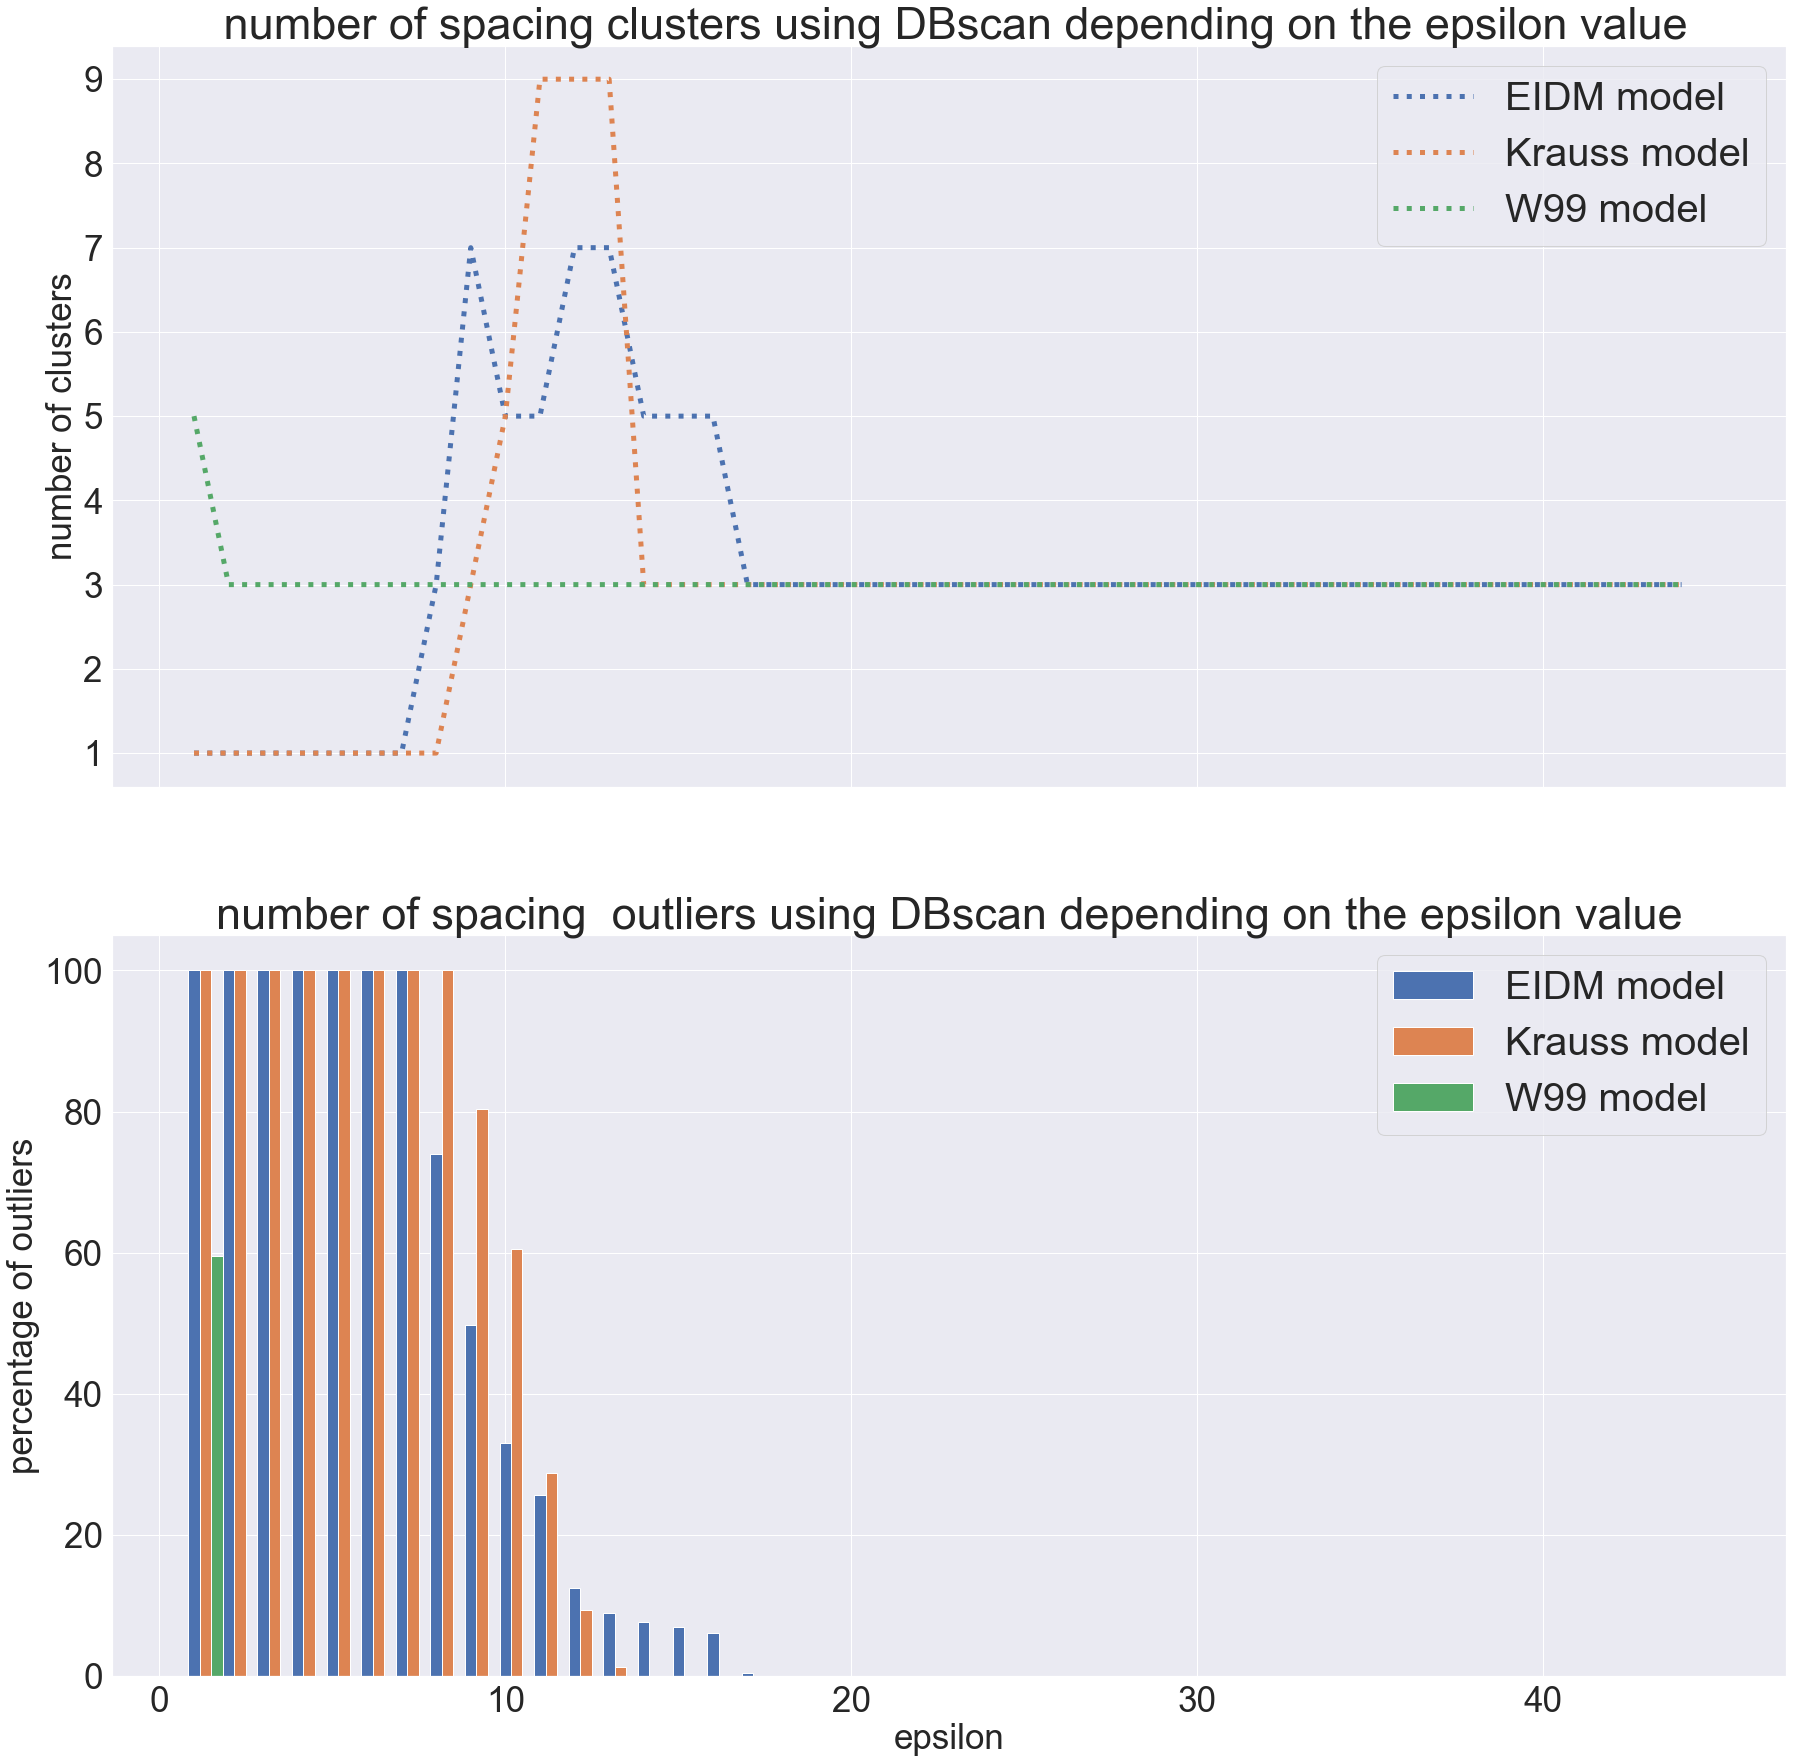

In [58]:
df_list = [DataFrame_spacing_EIDM, DataFrame_spacing_Krauss, DataFrame_spacing_W99]
name_columns = ['EIDM spacing','Krauss spacing', 'W99 spacing']
eps_list = [k for k in range(1,45)]
indicator_name = 'spacing'
tick_list = [k for k in range (0,10)]
plot_based_on_epsilon(eps_list, df_list, name_columns, indicator_name, tick_list)

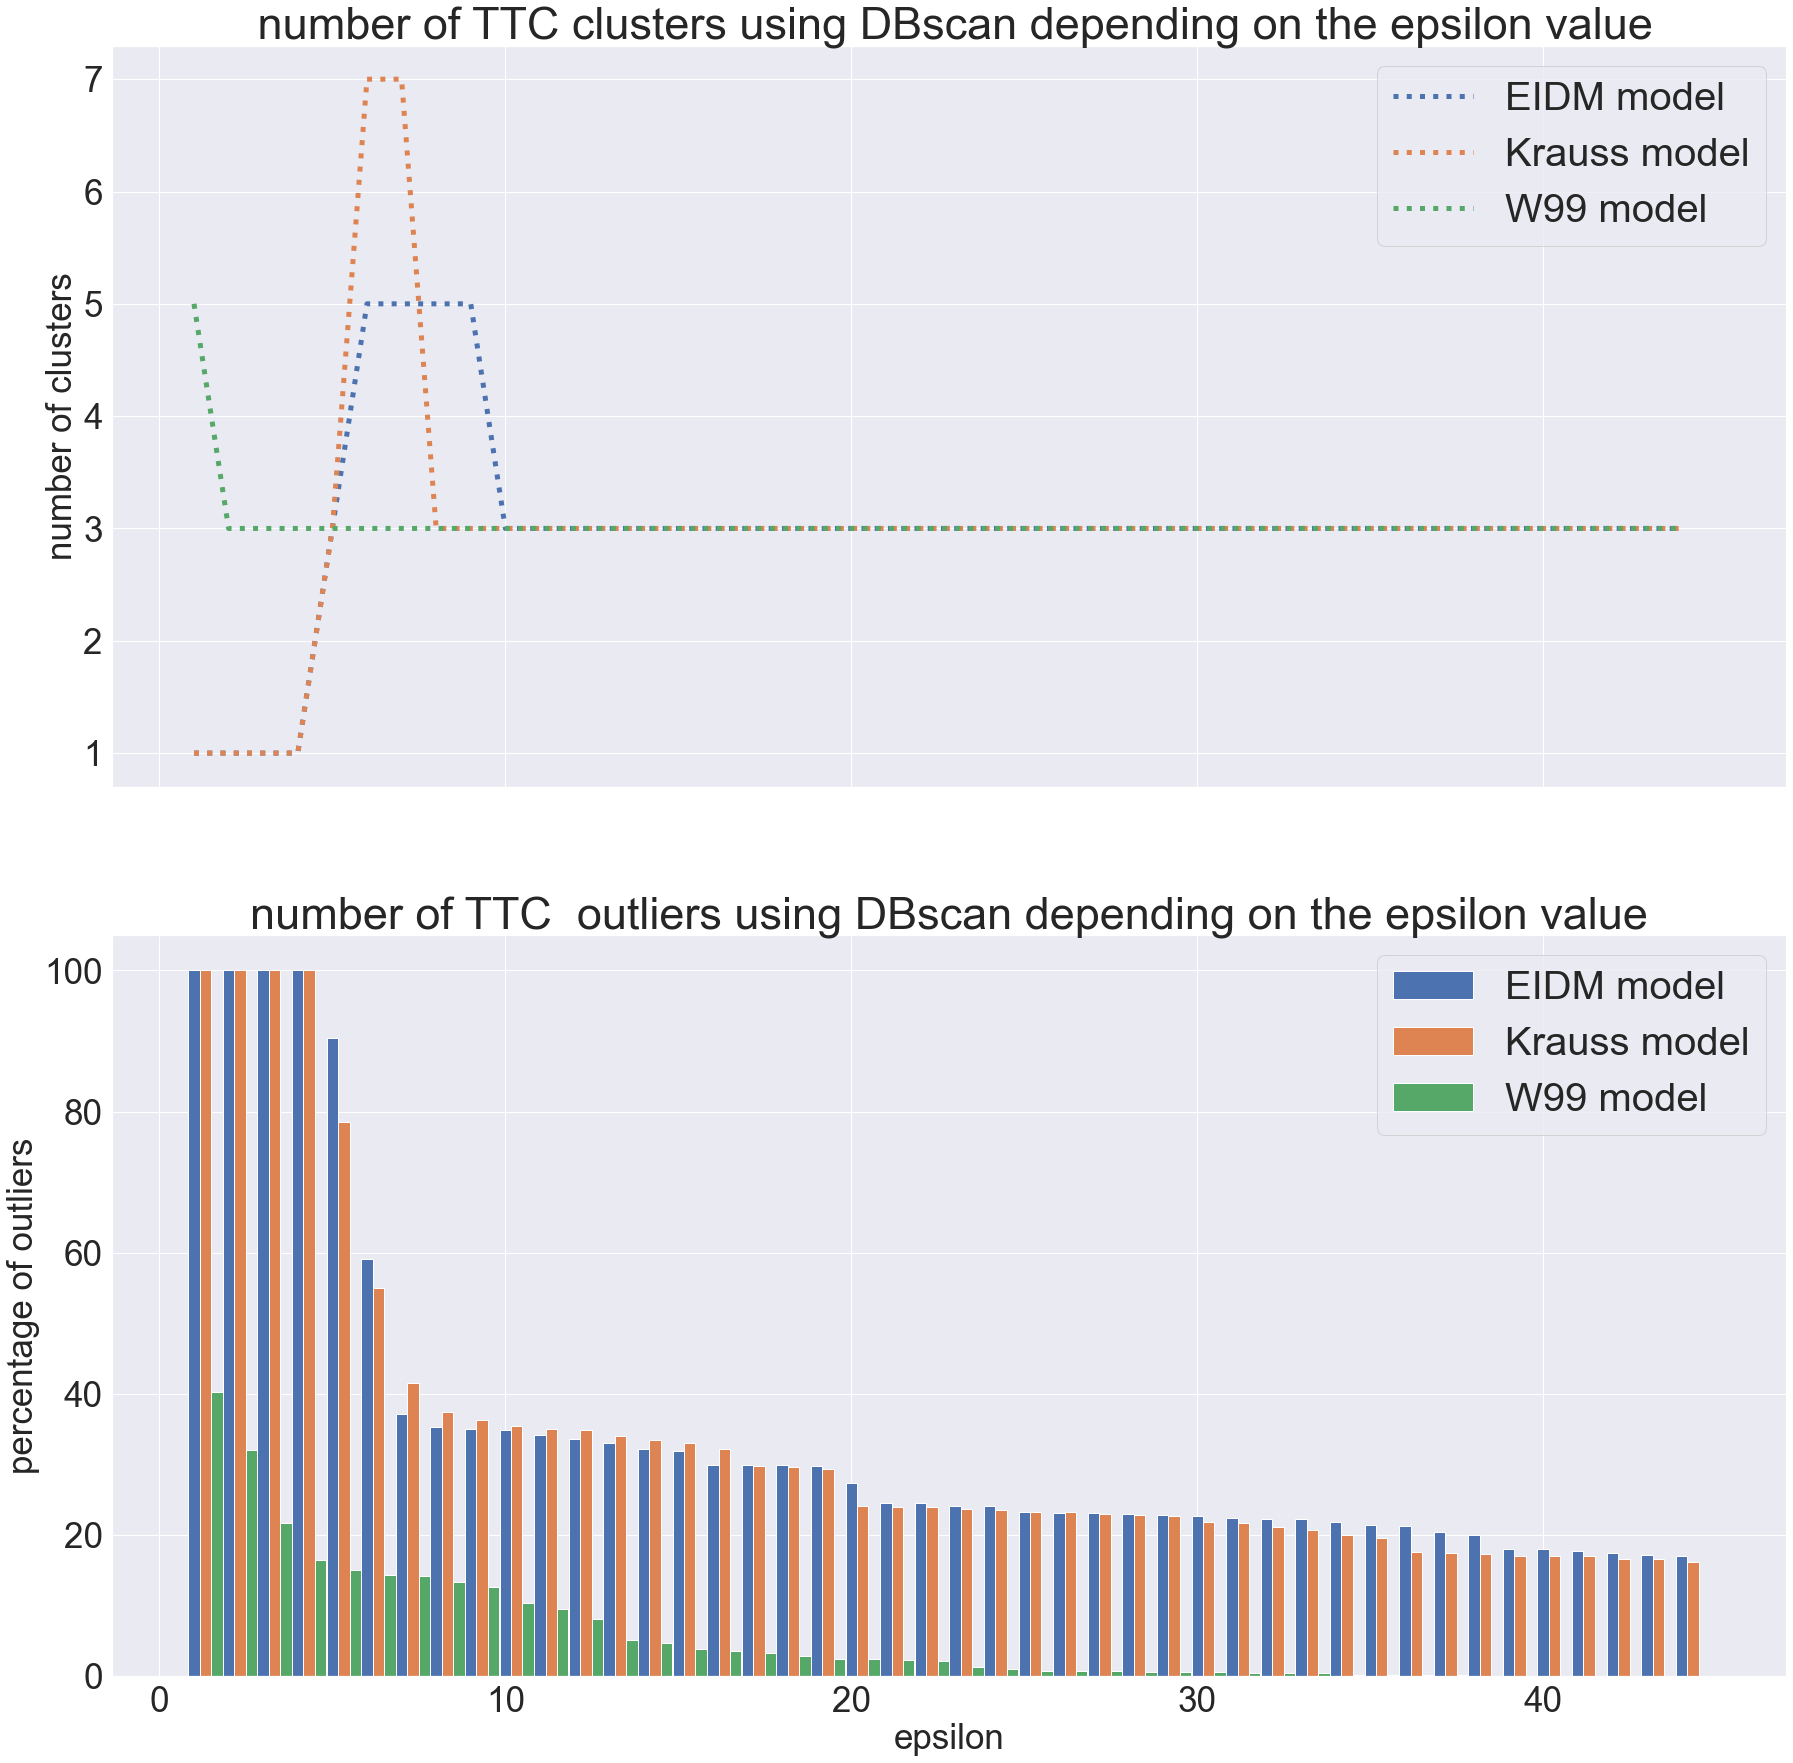

In [59]:
df_list = [DataFrame_TTC_EIDM, DataFrame_TTC_Krauss,DataFrame_TTC_W99]
name_columns = ['EIDM TTC','Krauss TTC', 'W99 TTC']
eps_list = [k for k in range(1,45)]
indicator_name = 'TTC'
tick_list = [k for k in range (0,10)]
plot_based_on_epsilon(eps_list, df_list, name_columns, indicator_name, tick_list)

### <span style="color:green"> Kmeans clustering </span>

Then we compute Kmeans clustering, to determine the ideal cluster number we use the WCSS elbow method

In [40]:
def choosing_cluster_number(DataFrame):
    wcss = []
    for i in range(1,11):
        model = KMeans(n_clusters = i, init = 'k-means++')
        model.fit(DataFrame)
        wcss.append(model.inertia_)
    return wcss


Text(0.5, 1.0, 'W99 TTC')

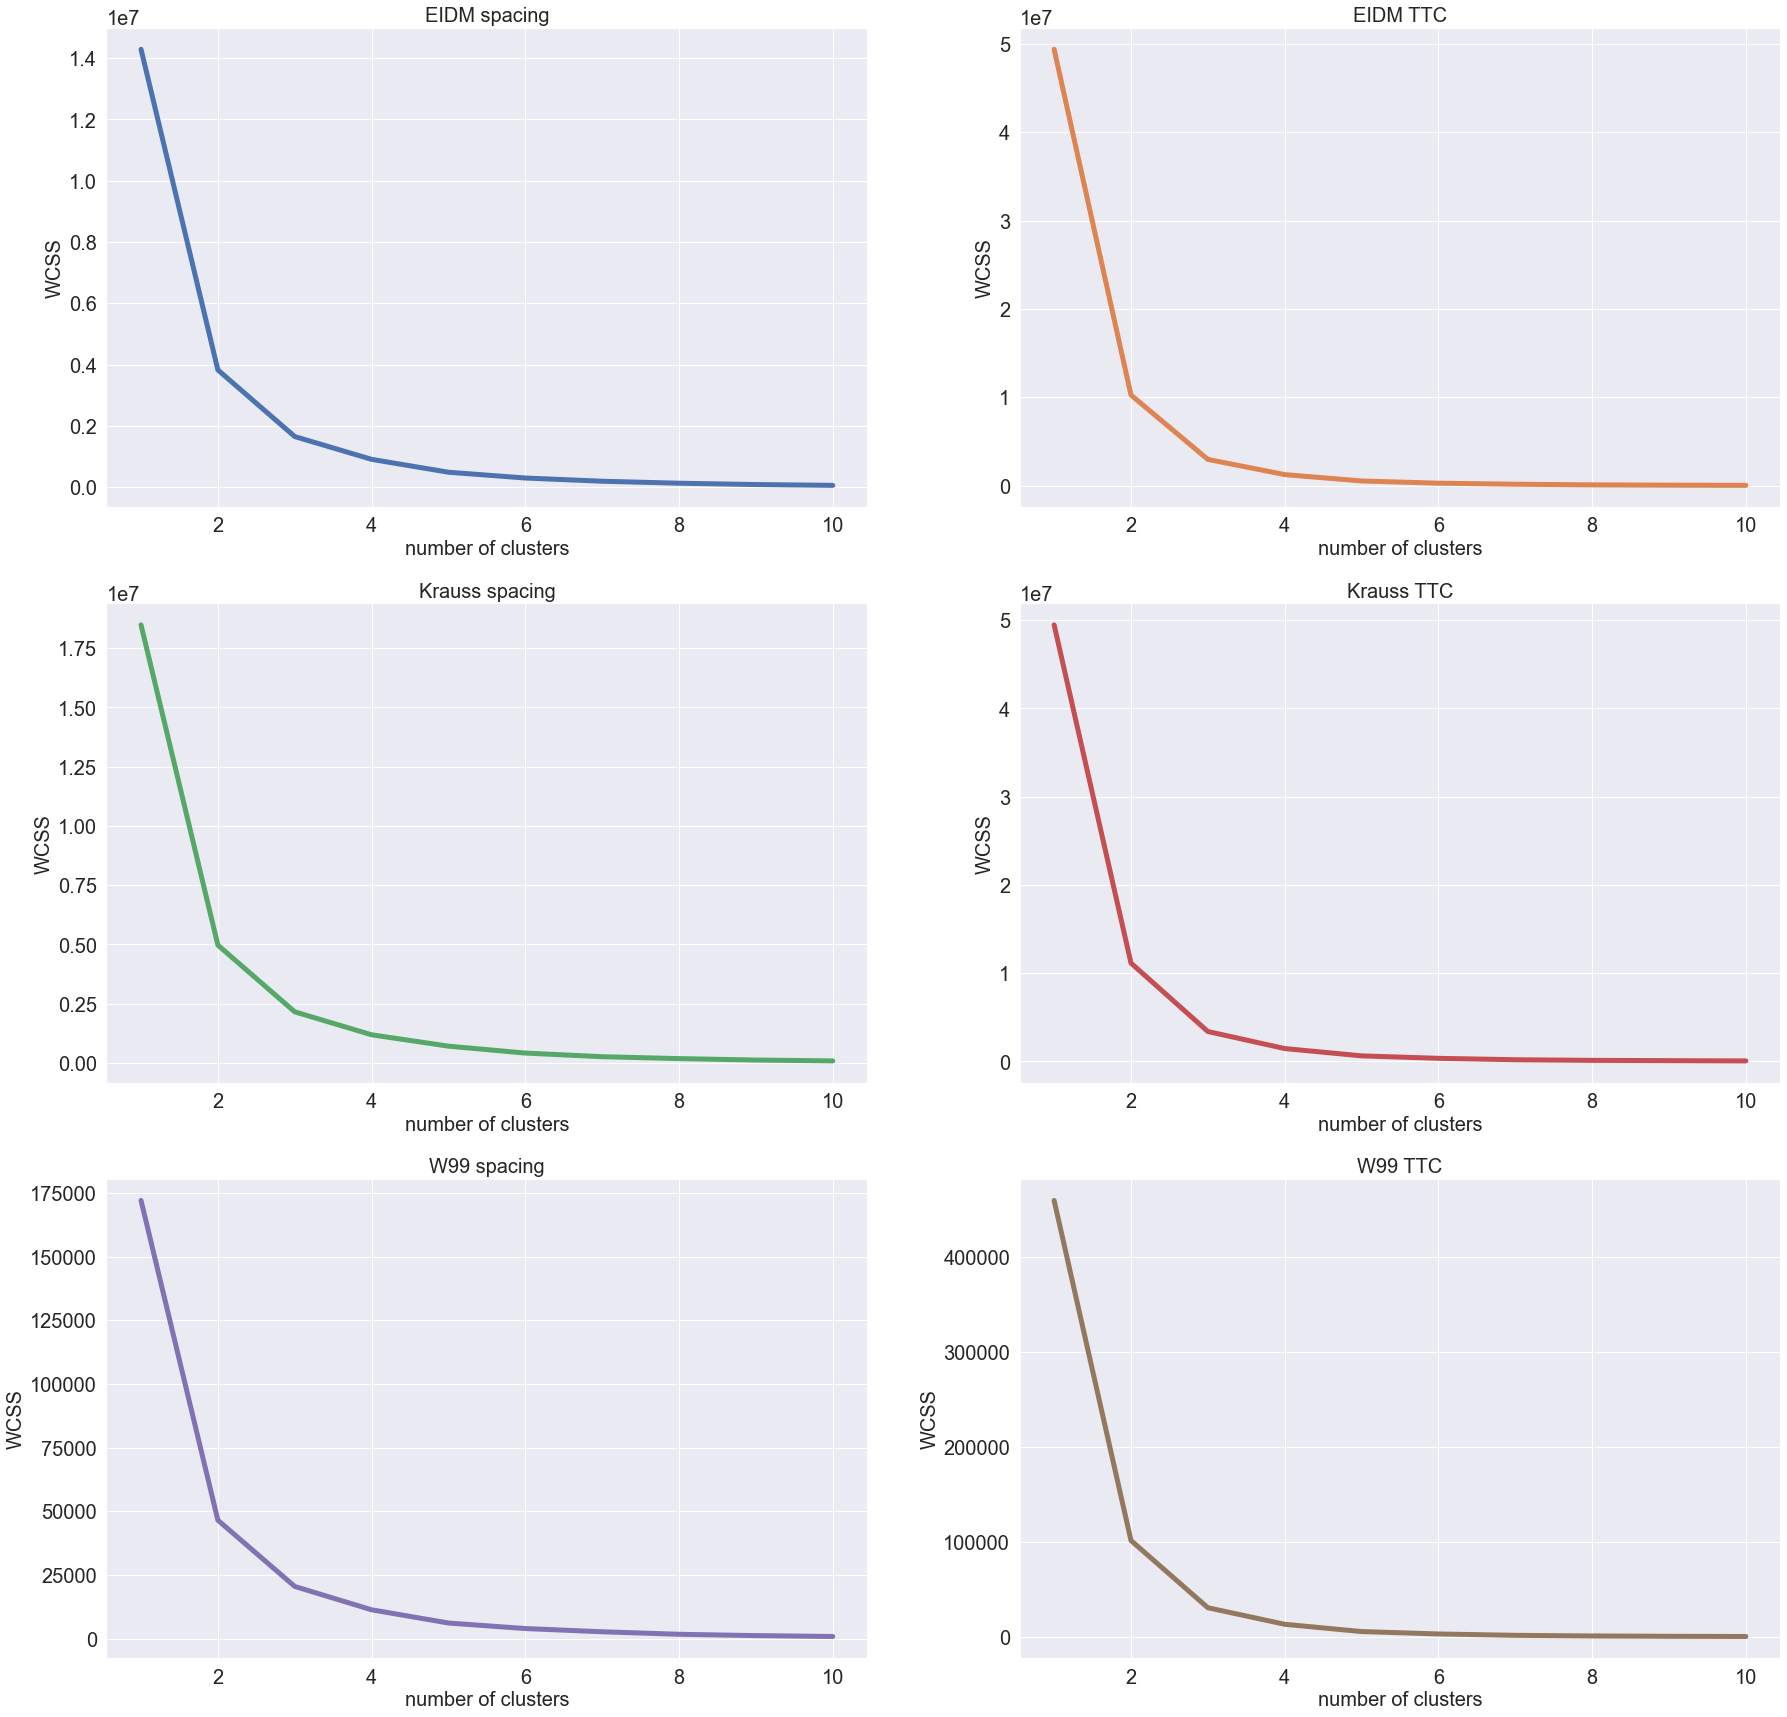

In [95]:
palette = itertools.cycle(sns.color_palette()) 

names = list(DataFrame_spacing_Krauss.T.index)
cluster_DataFrame= pd.DataFrame(names)
cluster_DataFrame.columns = ['scenario']
fig, axs = plt.subplots(3, 2,figsize=(30,30)) #creating a subplot 

wcss = choosing_cluster_number(DataFrame_spacing_EIDM)
axs[0,0].plot(list(k for k in range(1,11)), wcss,linewidth =5, color = next(palette))
axs[0,0].set_xlabel('number of clusters', size = 20)
axs[0,0].set_ylabel('WCSS', size = 20)
axs[0,0].set_title('EIDM spacing', size = 20)

wcss = choosing_cluster_number(DataFrame_TTC_EIDM)
axs[0,1].plot(list(k for k in range(1,11)), wcss,linewidth =5, color = next(palette))
axs[0,1].set_xlabel('number of clusters', size = 20)
axs[0,1].set_ylabel('WCSS', size = 20)
axs[0,1].set_title('EIDM TTC', size = 20)

wcss = choosing_cluster_number(DataFrame_spacing_Krauss)
axs[1,0].plot(list(k for k in range(1,11)), wcss,linewidth =5, color = next(palette))
axs[1,0].set_xlabel('number of clusters', size = 20)
axs[1,0].set_ylabel('WCSS', size = 20)
axs[1,0].set_title('Krauss spacing', size = 20)

wcss = choosing_cluster_number(DataFrame_TTC_Krauss)
axs[1,1].plot(list(k for k in range(1,11)),wcss,linewidth =5, color = next(palette))
axs[1,1].set_xlabel('number of clusters', size = 20)
axs[1,1].set_ylabel('WCSS', size = 20)
axs[1,1].set_title('Krauss TTC', size = 20)

wcss = choosing_cluster_number(DataFrame_spacing_W99)
axs[2,0].plot(list(k for k in range(1,11)), wcss,linewidth =5, color = next(palette))
axs[2,0].set_xlabel('number of clusters', size = 20)
axs[2,0].set_ylabel('WCSS', size = 20)
axs[2,0].set_title('W99 spacing', size = 20)

wcss = choosing_cluster_number(DataFrame_TTC_W99)
axs[2,1].plot(list(k for k in range(1,11)), wcss,linewidth =5, color = next(palette))
axs[2,1].set_xlabel('number of clusters', size = 20)
axs[2,1].set_ylabel('WCSS', size = 20)
axs[2,1].set_title('W99 TTC', size = 20)

The elbow method gives us 5 clusters to be created for the spacing indicator and 5 for the TTC indicator

In [61]:
def clustering_data(DataFrame, clusters) : 
    #function to cluster using kmeans algorithm
    model = MiniBatchKMeans(n_clusters= clusters)
    labels = model.fit_predict(DataFrame) #apply kmeans to the twentile dataframe
    results = pd.DataFrame([DataFrame.index,labels]).T
    results.columns = ['scenario', 'label'] #creating a dataframe that computes the cluster assigned to a sample
    centers = np.array(model.cluster_centers_) #exporting kmeans centroids
    closest, _ = pairwise_distances_argmin_min(model.cluster_centers_, DataFrame)
    return results, centers, closest

In [63]:
df_list = [DataFrame_spacing_EIDM, DataFrame_TTC_EIDM, DataFrame_spacing_Krauss, DataFrame_TTC_Krauss, DataFrame_spacing_W99, DataFrame_TTC_W99]
name_columns = ['EIDM spacing', 'EIDM TTC','Krauss spacing', 'Krauss TTC','W99 spacing','W99 TTC']
names = list(DataFrame_spacing_EIDM.T.index)
cluster_DataFrame_kmeans= pd.DataFrame(names)
cluster_DataFrame_kmeans.columns = ['scenario']
nb_cluster_list = [5,5,5,5,5,5]#number of clusters to be created
dico_closest = {}
for k in range (len(df_list)) : #clustering the entire set of twentiles for both TTC and spacing
    results, centers, closest = clustering_data(df_list[k].T,nb_cluster_list[k])
    cluster_DataFrame_kmeans[name_columns[k] + '_cluster']= results['label']
    dico_closest[name_columns[k]] = closest
cluster_DataFrame_kmeans.set_index('scenario',inplace=True)
for k in cluster_DataFrame.columns : 
    if k != 'scenario':
        cluster_DataFrame_kmeans[k] = cluster_DataFrame_kmeans[k].astype(float)
cluster_DataFrame_kmeans

,EIDM spacing_cluster,EIDM TTC_cluster,Krauss spacing_cluster,Krauss TTC_cluster,W99 spacing_cluster,W99 TTC_cluster
scenario,,,,,,
bottleneck 2 lanes to 1 to 2 normal weather_2200 0 ACCEIDM.sumocfgreplication num 0.csv,1,3,3,0,0,2
bottleneck 2 lanes to 1 to 2 normal weather_2200 0 ACCEIDM.sumocfgreplication num 1.csv,1,3,3,0,0,2
bottleneck 2 lanes to 1 to 2 normal weather_2200 0 ACCEIDM.sumocfgreplication num 2.csv,1,3,3,0,3,2
bottleneck 2 lanes to 1 to 2 normal weather_2200 0 ACCEIDM.sumocfgreplication num 3.csv,1,3,3,0,0,2
bottleneck 2 lanes to 1 to 2 normal weather_2200 0 ACCEIDM.sumocfgreplication num 4.csv,1,3,3,0,0,2
...,...,...,...,...,...,...
works 3 lanes to 2 to 3 rain_4400 25 ACCEIDM.sumocfgreplication num 5.csv,0,3,1,0,2,2
works 3 lanes to 2 to 3 rain_4400 25 ACCEIDM.sumocfgreplication num 6.csv,0,3,1,0,2,2
works 3 lanes to 2 to 3 rain_4400 25 ACCEIDM.sumocfgreplication num 7.csv,0,3,1,0,2,2


In [66]:
def plot_cluster_distribution(indicator, cluster_df, cluster_number, indicator_df,len_y) : 
    """"input indicator to be plotted, dataframe that describes the cluster number, list of cluster names
        for this indicator, dataframe that contains the twentiles for this indicator"""
    sample_number = len(cluster_df[indicator+'_cluster']) #computing the importion in percentage of each cluster
    count_df = pd.DataFrame(cluster_df[indicator+'_cluster'].value_counts())
    count_df.sort_index(axis=0, inplace = True)
    count_df['percentage'] = count_df[indicator+'_cluster']/sample_number*100
    y_list = [k for k in range(1,len_y)]
    plt.rcParams['figure.figsize'] = (20, 15)
    custom_lines = []
    palette = itertools.cycle(sns.color_palette())
    legend_elements = []
    for cluster in cluster_number : 
        color=next(palette)
        df_out = pd.DataFrame()
        for k in tqdm_notebook ( range(len(cluster_df[indicator+'_cluster']))):
            if cluster_df[indicator+'_cluster'][k]==cluster :
                try :
                    liste = list(indicator_df[cluster_df.index[k]])
                    plt.plot(liste, y_list, color = color, alpha=0.3) #plotting the twentiles belonging to the cluster
                except KeyError :
                    continue
        legend_elements.append(Line2D([0], [0], color=color, lw=4, label='cluster ' + str (cluster)+
                                     ' (' + str(round(count_df['percentage'][cluster],2)) + '% of samples)'))
        #creating a legend with the cluster number and its sample share
    plt.ylabel('twentile', size = 25)       
    plt.xlabel('TTC (s)', size = 25)    
    plt.legend(handles=legend_elements, loc='best', prop={'size': 25})
    plt.title(indicator + ' twentile distribution and clusters', size = 45)
    plt.show()
    return 

In [ ]:
plot_cluster_distribution('EIDM spacing',cluster_DataFrame_kmeans , [0, 1, 2, 3 ,4],DataFrame_spacing_EIDM,20 )
plot_cluster_distribution('EIDM TTC',cluster_DataFrame_kmeans , [0, 1, 2,3,4],DataFrame_TTC_EIDM,17)
plot_cluster_distribution('Krauss spacing',cluster_DataFrame_kmeans , [0, 1, 2, 3 ,4],DataFrame_spacing_Krauss,20)
plot_cluster_distribution('Krauss TTC',cluster_DataFrame_kmeans , [0, 1, 2,3,4],DataFrame_TTC_Krauss,17)
plot_cluster_distribution('W99 spacing',cluster_DataFrame_kmeans , [0, 1, 2, 3 ,4],DataFrame_spacing_W99,20)
plot_cluster_distribution('W99 TTC',cluster_DataFrame_kmeans , [0, 1, 2,3,4],DataFrame_TTC_W99,17)

In [96]:
#plot heatmaps
figA = px.density_heatmap(cluster_DataFrame_kmeans, x="EIDM spacing_cluster", y="Krauss spacing_cluster",
                         marginal_x="histogram", marginal_y="histogram",
                          text_auto=True,
                          labels={
                     "EIDM spacing_cluster": "EIDM spacing cluster",
                     "Krauss spacing_cluster": "Krauss spacing cluster"
                 },
                title="heatmap of the spacing clusters EIDM vs Krauss"
                        )
figB = px.density_heatmap(cluster_DataFrame_kmeans, x="EIDM TTC_cluster", y="Krauss TTC_cluster",
                         marginal_x="histogram", marginal_y="histogram",
                          text_auto =True,
                          labels={
                     "EIDM TTC_cluster": "EIDM TTC cluster",
                     "Krauss TTC_cluster": "Krauss TTC cluster EIDM vs Krauss"
                 },
                title="heatmap of the TTC clusters"
                         )
figC = px.density_heatmap(cluster_DataFrame_kmeans, x="EIDM spacing_cluster", y="W99 spacing_cluster",
                         marginal_x="histogram", marginal_y="histogram",
                          text_auto =True,
                          labels={
                     "EIDM TTC_cluster": "EIDM TTC cluster",
                     "W99 spacing_cluster": "W99 spacing cluster"
                 },
                title="heatmap of the spacing clusters EIDM vs W99"
                         )
figD = px.density_heatmap(cluster_DataFrame_kmeans, x="EIDM TTC_cluster", y="W99 TTC_cluster",
                         marginal_x="histogram", marginal_y="histogram",
                          text_auto =True,
                          labels={
                     "EIDM TTC_cluster": "EIDM TTC cluster",
                     "W99 TTC_cluster": "W99 TTC cluster"
                 },
                title="heatmap of the TTC clusters EIDM vs W99"
                         )
figE = px.density_heatmap(cluster_DataFrame_kmeans, x="Krauss spacing_cluster", y="W99 spacing_cluster",
                         marginal_x="histogram", marginal_y="histogram",
                          text_auto =True,
                          labels={
                     "Krauss TTC_cluster": "Krauss spacing cluster",
                     "W99 TTC_cluster": "W99 spacing cluster"
                 },
                title="heatmap of the spacing clusters Krauss vs W99"
                         )

figF = px.density_heatmap(cluster_DataFrame_kmeans, x="Krauss TTC_cluster", y="W99 TTC_cluster",
                         marginal_x="histogram", marginal_y="histogram",
                          text_auto =True,
                          labels={
                     "Krauss TTC_cluster": "Krauss TTC cluster",
                     "W99 TTC_cluster": "W99 TTC cluster"
                 },
                title="heatmap of the TTC clusters Krauss vs W99"
                         )
figA.show()
figB.show()
figC.show()
figD.show()
figE.show()
figF.show()

### <span style="color:green"> HCA clustering </span>


We compute a HCA clustering

In [90]:
ZsEIDM = linkage(DataFrame_spacing_EIDM.T, 'ward')
Zskrauss = linkage(DataFrame_spacing_Krauss.T, 'ward')
ZsW99 = linkage(DataFrame_spacing_W99.T, 'ward')

ZTTCEIDM = linkage(DataFrame_TTC_EIDM.T, 'ward')
ZTTCkrauss = linkage(DataFrame_TTC_Krauss.T, 'ward')
ZTTCW99 = linkage(DataFrame_TTC_W99.T, 'ward')

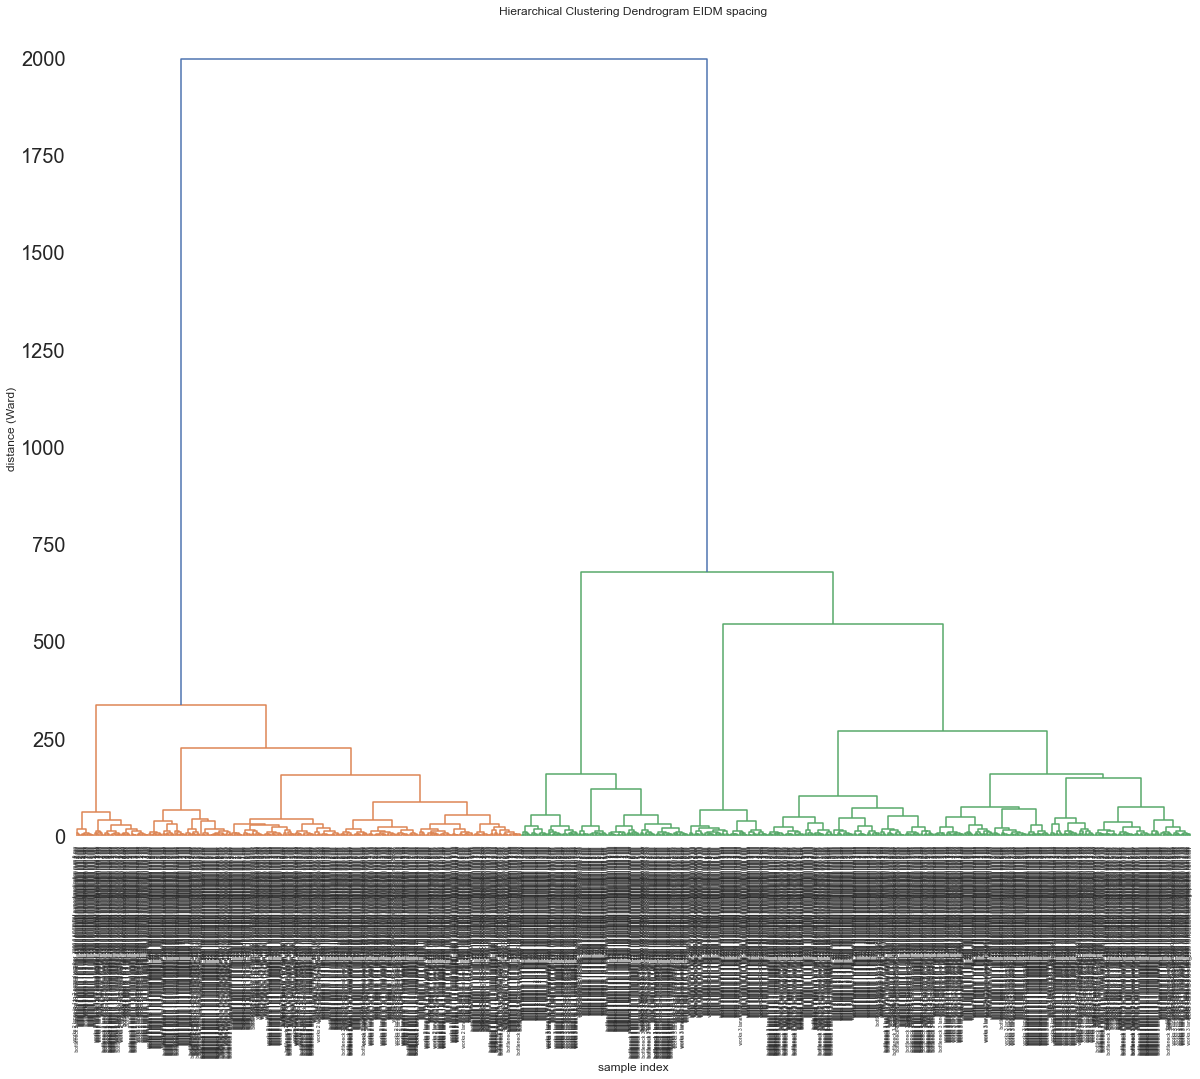

In [80]:
#creation of dendrograms to determine the number of clusters we have to compute
# Plot title
plt.title('Hierarchical Clustering Dendrogram EIDM spacing')

# Plot axis labels
plt.xlabel('sample index')
plt.ylabel('distance (Ward)')

# Make the dendrogram
dendrogram(ZsEIDM, labels=DataFrame_spacing_EIDM.T.index, leaf_rotation=90)

# Show the graph
plt.show()

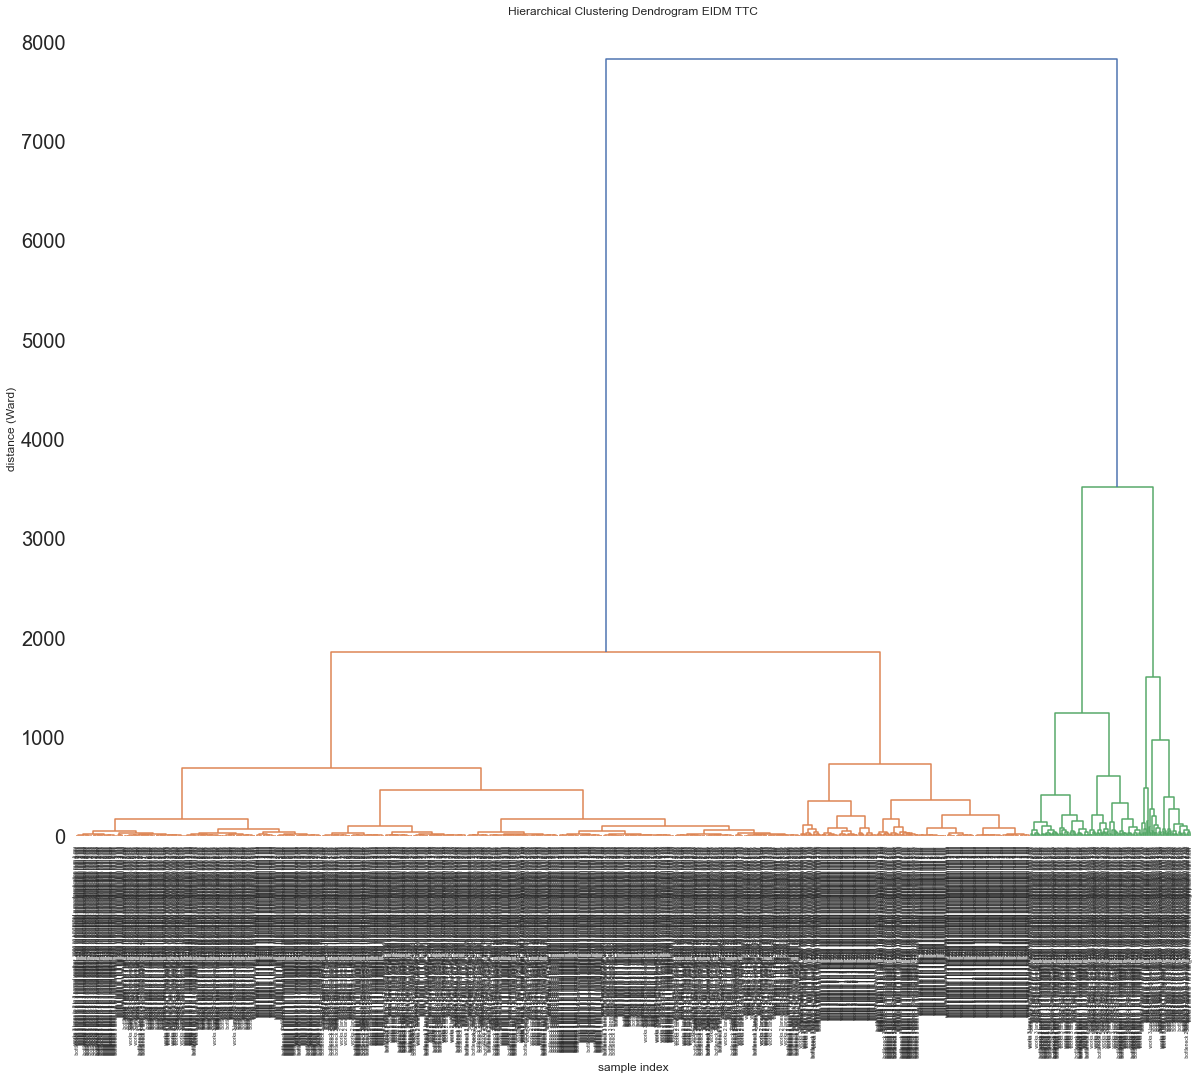

In [81]:
# Plot title
plt.title('Hierarchical Clustering Dendrogram EIDM TTC')

# Plot axis labels
plt.xlabel('sample index')
plt.ylabel('distance (Ward)')

# Make the dendrogram
dendrogram(ZTTCEIDM, labels=DataFrame_TTC_EIDM.T.index, leaf_rotation=90)

# Show the graph
plt.show()

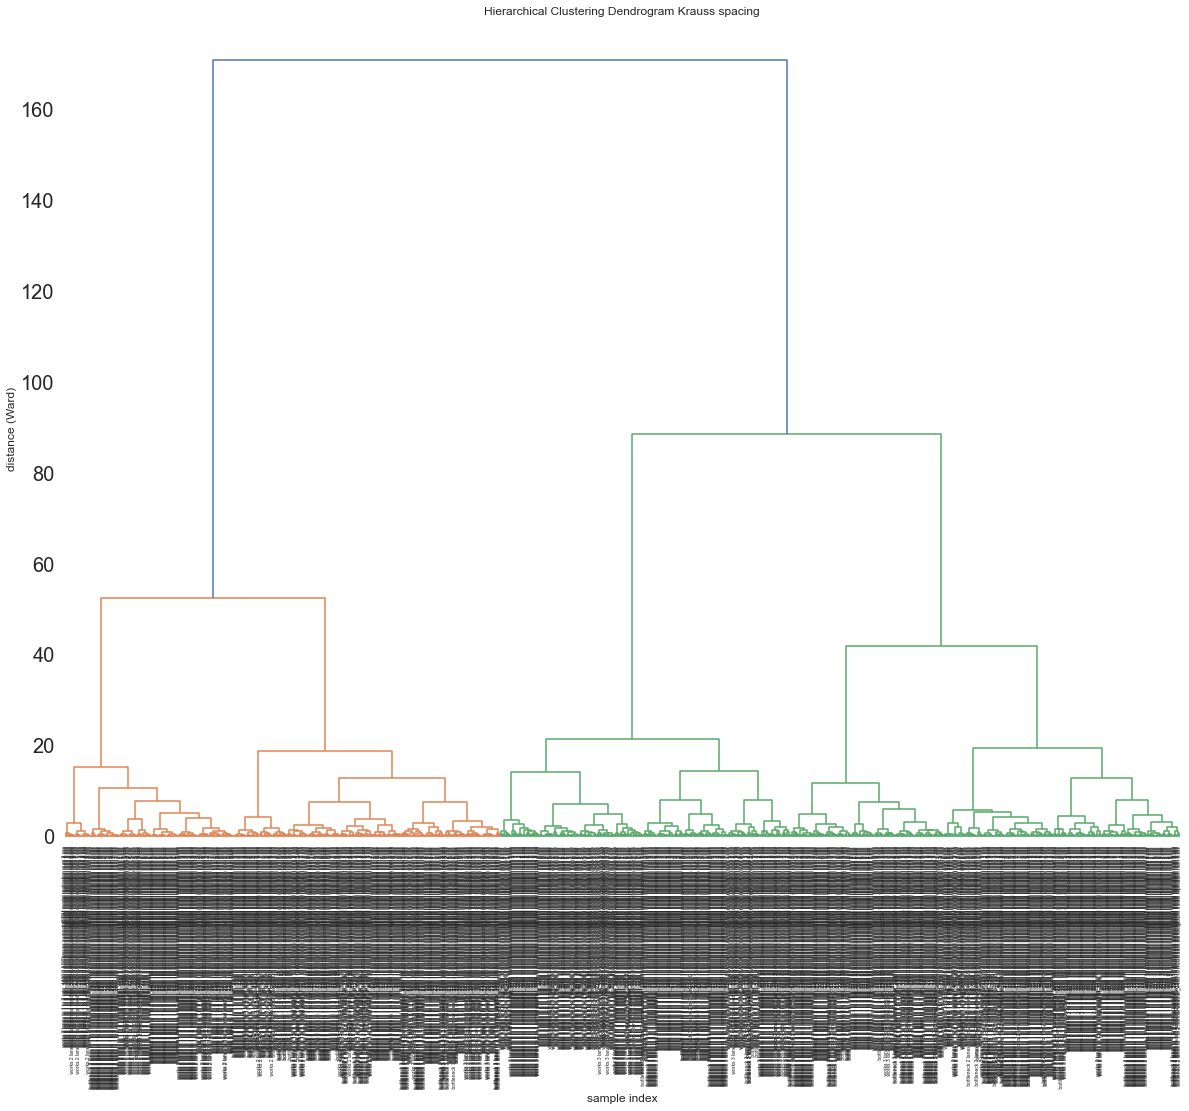

In [82]:
# Plot title
plt.title('Hierarchical Clustering Dendrogram Krauss spacing')

# Plot axis labels
plt.xlabel('sample index')
plt.ylabel('distance (Ward)')

# Make the dendrogram
dendrogram(Zskrauss, labels=DataFrame_spacing_Krauss.T.index, leaf_rotation=90)

# Show the graph
plt.show()

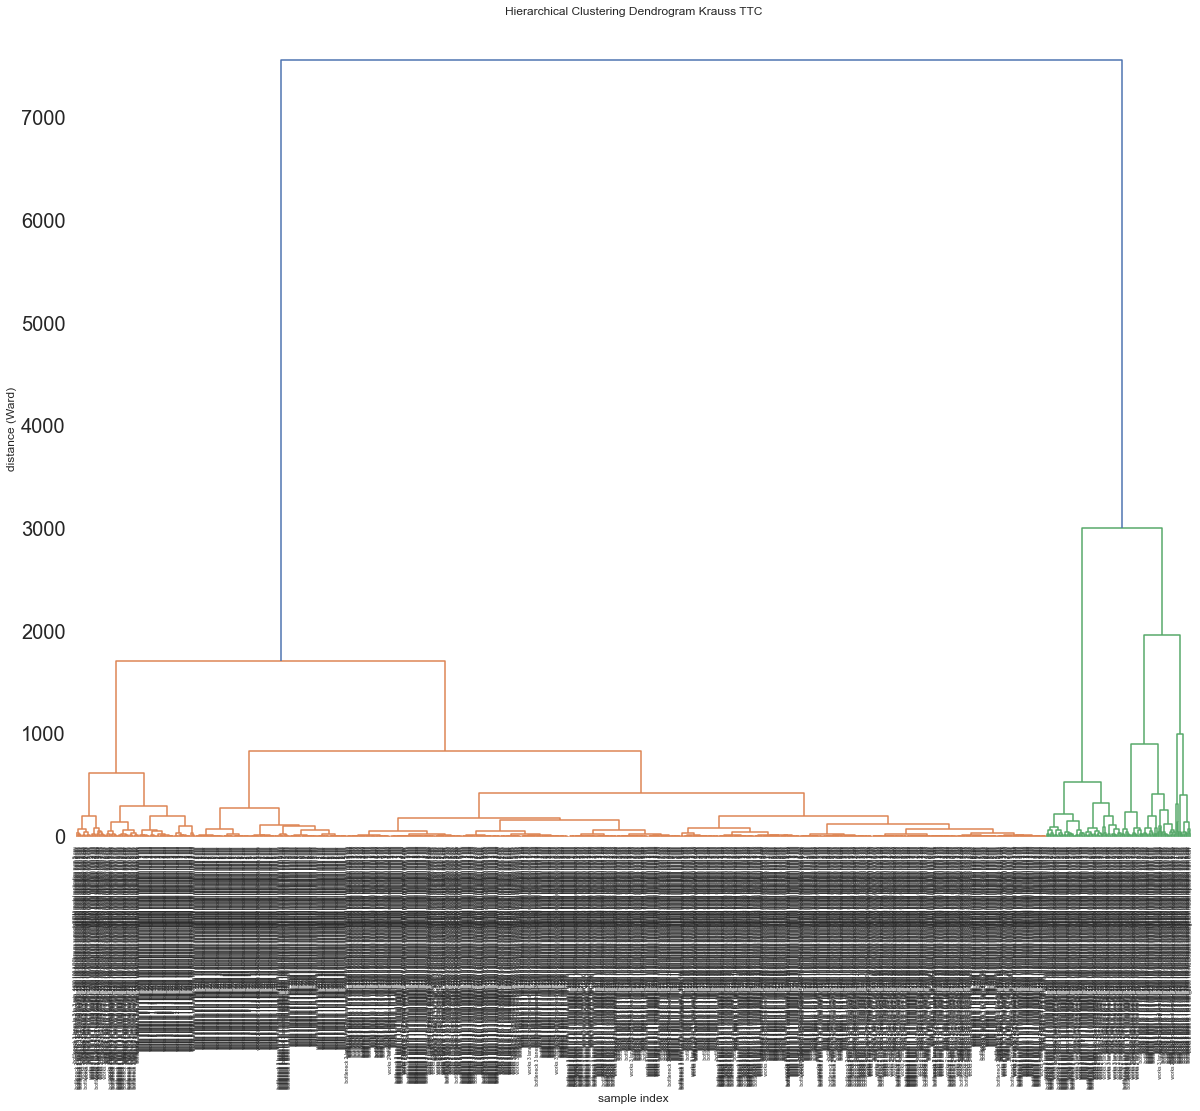

In [83]:
# Plot title
plt.title('Hierarchical Clustering Dendrogram Krauss TTC')

# Plot axis labels
plt.xlabel('sample index')
plt.ylabel('distance (Ward)')

# Make the dendrogram
dendrogram(ZTTCkrauss, labels=DataFrame_TTC_Krauss.T.index, leaf_rotation=90)

# Show the graph
plt.show()

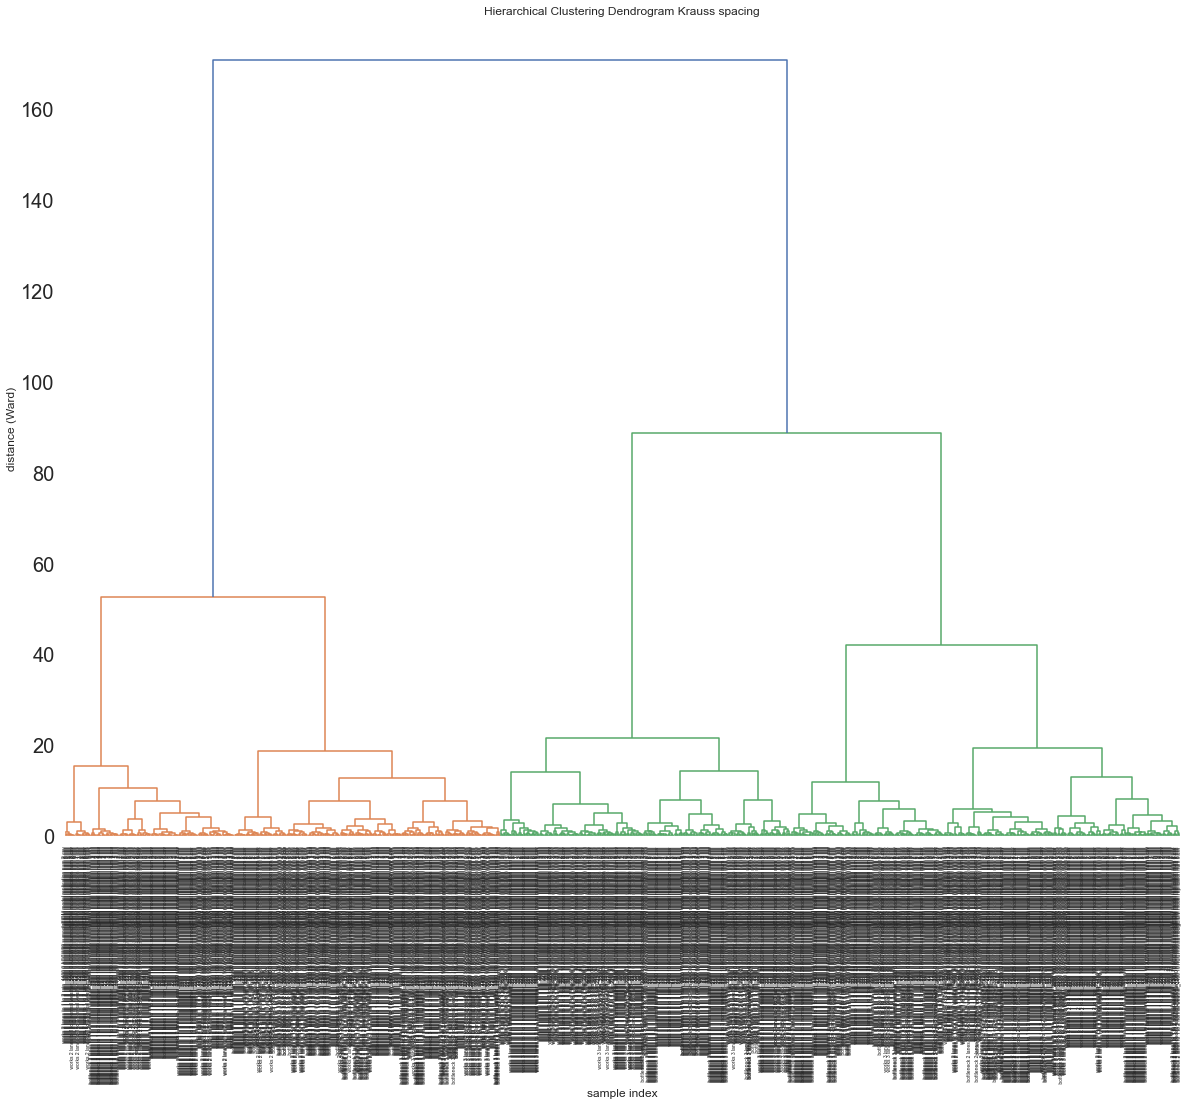

In [86]:
# Plot title
plt.title('Hierarchical Clustering Dendrogram Krauss spacing')

# Plot axis labels
plt.xlabel('sample index')
plt.ylabel('distance (Ward)')

# Make the dendrogram
dendrogram(ZsW99, labels=DataFrame_spacing_W99.T.index, leaf_rotation=90)

# Show the graph
plt.show()

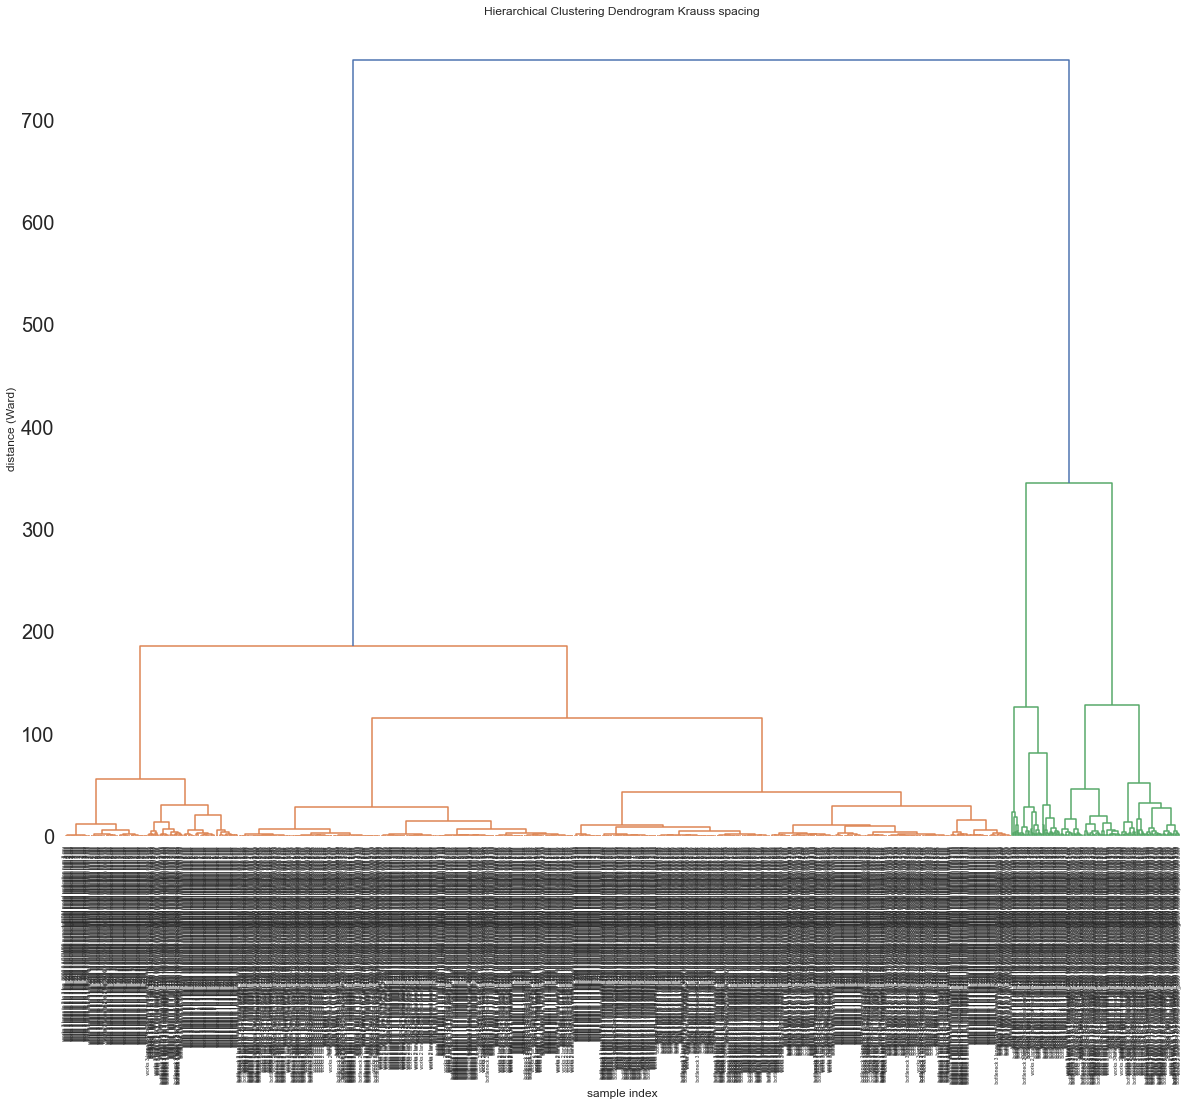

In [92]:
# Plot title
plt.title('Hierarchical Clustering Dendrogram Krauss spacing')

# Plot axis labels
plt.xlabel('sample index')
plt.ylabel('distance (Ward)')

# Make the dendrogram
dendrogram(ZTTCW99, labels=DataFrame_TTC_W99.T.index, leaf_rotation=90)

# Show the graph
plt.show()

In [91]:
#now we wan cluster the different clusters using the cluster numbers that our dendrograms gave us
df_list = [DataFrame_spacing_EIDM, DataFrame_TTC_EIDM, DataFrame_spacing_Krauss, DataFrame_TTC_Krauss, DataFrame_spacing_W99, DataFrame_TTC_W99]
name_columns = ['EIDM spacing', 'EIDM TTC','Krauss spacing', 'Krauss TTC','W99 spacing','W99 TTC']
names = list(DataFrame_spacing_EIDM.T.index)
dendrogram_cluster_DataFrame= pd.DataFrame(names)
dendrogram_cluster_DataFrame.columns = ['scenario']
dendrogram_list = [5,7,5,7] #number of clusters to be created based on the dendrograms
dico_closest = {}
for k in range (len(df_list)) : 
    X = df_list[k].T
    cluster = AgglomerativeClustering(n_clusters=dendrogram_list[k], affinity='euclidean', linkage='ward')
    cluster.fit_predict(X)
    dendrogram_cluster_DataFrame[name_columns[k] + '_cluster']= cluster.labels_
dendrogram_cluster_DataFrame.set_index('scenario',inplace=True)
for k in dendrogram_cluster_DataFrame.columns : 
    dendrogram_cluster_DataFrame[k] = dendrogram_cluster_DataFrame[k].astype(float)
dendrogram_cluster_DataFrame

NameError: name 'DataFrame_EIDM_spacing' is not defined

In [ ]:
#plotting heatmaps 
figA = px.density_heatmap(dendrogram_cluster_DataFrame, x="EIDM spacing_cluster", y="Krauss spacing_cluster",
                         marginal_x="histogram", marginal_y="histogram",
                          text_auto=True,
                          labels={
                     "EIDM spacing_cluster": "EIDM spacing cluster",
                     "Krauss spacing_cluster": "Krauss spacing cluster"
                 },
                title="heatmap of the spacing clusters for the HCA"
                        )
figB = px.density_heatmap(dendrogram_cluster_DataFrame, x="EIDM TTC_cluster", y="Krauss TTC_cluster",
                         marginal_x="histogram", marginal_y="histogram",
                          text_auto =True,
                          labels={
                     "EIDM TTC_cluster": "EIDM TTC cluster",
                     "Krauss TTC_cluster": "Krauss TTC cluster"
                 },
                title="heatmap of the TTC clusters for the HCA"
                         )

figC = px.density_heatmap(dendrogram_cluster_DataFrame, x="EIDM spacing_cluster", y="W99 spacing_cluster",
                         marginal_x="histogram", marginal_y="histogram",
                          text_auto =True,
                          labels={
                     "EIDM TTC_cluster": "EIDM TTC cluster",
                     "W99 spacing_cluster": "W99 spacing cluster"
                 },
                title="heatmap of the spacing clusters EIDM vs W99"
                         )
figD = px.density_heatmap(dendrogram_cluster_DataFrame, x="EIDM TTC_cluster", y="W99 TTC_cluster",
                         marginal_x="histogram", marginal_y="histogram",
                          text_auto =True,
                          labels={
                     "EIDM TTC_cluster": "EIDM TTC cluster",
                     "W99 TTC_cluster": "W99 TTC cluster"
                 },
                title="heatmap of the TTC clusters EIDM vs W99"
                         )
figE = px.density_heatmap(dendrogram_cluster_DataFrame, x="Krauss spacing_cluster", y="W99 spacing_cluster",
                         marginal_x="histogram", marginal_y="histogram",
                          text_auto =True,
                          labels={
                     "Krauss TTC_cluster": "Krauss spacing cluster",
                     "W99 TTC_cluster": "W99 spacing cluster"
                 },
                title="heatmap of the spacing clusters Krauss vs W99"
                         )

figF = px.density_heatmap(dendrogram_cluster_DataFrame, x="Krauss TTC_cluster", y="W99 TTC_cluster",
                         marginal_x="histogram", marginal_y="histogram",
                          text_auto =True,
                          labels={
                     "Krauss TTC_cluster": "Krauss TTC cluster",
                     "W99 TTC_cluster": "W99 TTC cluster"
                 },
                title="heatmap of the TTC clusters Krauss vs W99"
                         )
figA.show()
figB.show()
figC.show()
figD.show()
figE.show()
figF.show()